# Prevendo *Customer Churn* em Operadoras de Telecom

## Importando as bibliotecas necessárias

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #importando o pacote pandas
import numpy as np #pacote numérico numpy
import time
import pickle
from itertools import product
from itertools import combinations

#visualização de dados
from matplotlib import pyplot as plt
import seaborn as sns #pacote seaborn para construção de gráficos


#SKLEARN
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler # importando função para a Padronização dos dados
from sklearn.metrics import plot_confusion_matrix #matriz de confusão
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#Importando pacotes de Tuning
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

#Importando os algoritmos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

## Criando uma função para explorar os dados

In [5]:
# Criando uma função que retorna um dataframe de descrição de dados (tal qual a função describe do pacote explore do R)
def explore_describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [len(df[coluna]) - df[coluna].count() for coluna in df.columns]
    df_out['na_pct'] = df_out.na/len(df_out.na)*100
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [min(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [max(df[coluna]) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [df[coluna].skew() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [df[coluna].kurt() if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['media_desvio'] = [round(df[coluna].mean()/df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                                'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    return(df_out)


## Importando o dataset de treino e teste

In [3]:
dados_treino = pd.read_csv("projeto4_telecom_treino.csv",header=0)
dados_teste = pd.read_csv("projeto4_telecom_teste.csv",header=0)
dados_treino

Unnamed: 0 state  account_length      area_code international_plan  \
0              1    KS             128  area_code_415                 no   
1              2    OH             107  area_code_415                 no   
2              3    NJ             137  area_code_415                 no   
3              4    OH              84  area_code_408                yes   
4              5    OK              75  area_code_415                yes   
...          ...   ...             ...            ...                ...   
3328        3329    AZ             192  area_code_415                 no   
3329        3330    WV              68  area_code_415                 no   
3330        3331    RI              28  area_code_510                 no   
3331        3332    CT             184  area_code_510                yes   
3332        3333    TN              74  area_code_415                 no   

     voice_mail_plan  number_vmail_messages  total_day_minutes  \
0                yes                     25              265.1   
1                yes                     26              161.6   
2                 no                      0              243.4   
3                 no                      0              299.4   
4                 no                      0              166.7   
...              ...                    ...                ...   
3328             yes                     36              156.2   
3329              no                      0              231.1   
3330              no                      0              180.8   
3331              no                      0              213.8   
3332             yes                     25              234.4   

      total_day_calls  total_day_charge  ...  total_eve_calls  \
0                 110             45.07  ...               99   
1                 123             27.47  ...              103   
2                 114             41.38  ...              110   
3                  71             50.90  ...               88   
4                 113             28.34  ...              122   
...               ...               ...  ...              ...   
3328               77             26.55  ...              126   
3329               57             39.29  ...               55   
3330              109             30.74  ...               58   
3331              105             36.35  ...               84   
3332              113             39.85  ...               82   

      total_eve_charge  total_night_minutes  total_night_calls  \
0                16.78                244.7                 91   
1                16.62                254.4                103   
2                10.30                162.6                104   
3                 5.26                196.9                 89   
4                12.61                186.9                121   
...                ...                  ...                ...   
3328             18.32                279.1                 83   
3329             13.04                191.3                123   
3330             24.55                191.9                 91   
3331             13.57                139.2                137   
3332             22.60                241.4                 77   

      total_night_charge  total_intl_minutes  total_intl_calls  \
0                  11.01                10.0                 3   
1                  11.45                13.7                 3   
2                   7.32                12.2                 5   
3                   8.86                 6.6                 7   
4                   8.41                10.1                 3   
...                  ...                 ...               ...   
3328               12.56                 9.9                 6   
3329                8.61                 9.6                 4   
3330                8.64                14.1                 6   
3331                6.26                 5.0                10   


In [7]:
#Primeira coluna contém o indice de alguma exportação do Python. Dessa forma, vamos remover essa coluna
dados_treino = dados_treino.loc[:,'state':]
dados_teste = dados_teste.loc[:,'state':]
dados_treino

state  account_length      area_code international_plan voice_mail_plan  \
0       KS             128  area_code_415                 no             yes   
1       OH             107  area_code_415                 no             yes   
2       NJ             137  area_code_415                 no              no   
3       OH              84  area_code_408                yes              no   
4       OK              75  area_code_415                yes              no   
...    ...             ...            ...                ...             ...   
3328    AZ             192  area_code_415                 no             yes   
3329    WV              68  area_code_415                 no              no   
3330    RI              28  area_code_510                 no              no   
3331    CT             184  area_code_510                yes              no   
3332    TN              74  area_code_415                 no             yes   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3328                     36              156.2               77   
3329                      0              231.1               57   
3330                      0              180.8              109   
3331                      0              213.8              105   
3332                     25              234.4              113   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                45.07              197.4               99             16.78   
1                27.47              195.5              103             16.62   
2                41.38              121.2              110             10.30   
3                50.90               61.9               88              5.26   
4                28.34              148.3              122             12.61   
...                ...                ...              ...               ...   
3328             26.55              215.5              126             18.32   
3329             39.29              153.4               55             13.04   
3330             30.74              288.8               58             24.55   
3331             36.35              159.6               84             13.57   
3332             39.85              265.9               82             22.60   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   244.7                 91               11.01   
1                   254.4                103               11.45   
2                   162.6                104                7.32   
3                   196.9                 89                8.86   
4                   186.9                121                8.41   
...                   ...                ...                 ...   
3328                279.1                 83               12.56   
3329                191.3                123                8.61   
3330                191.9                 91                8.64   
3331                139.2                137                6.26   
3332                241.4                 77               10.86   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   10.0                 3               2.70   
1                   13.7                 3               3.70   
2                   12.2                 5               3.29   
3                    6.6                 7               1.78   
4                   10.1                 3               2.73   
...                  ...               ...                ...   
3328  

In [71]:
#Vamos juntos os dados de treino e teste em um único dataset, para realizar as transformações que são iguais para ambos
dados = pd.concat([dados_treino,dados_teste],keys = ['treino','teste'],names = ['tipo_dado','index'])
dados

state  account_length      area_code international_plan  \
tipo_dado index                                                           
treino    0        KS             128  area_code_415                 no   
          1        OH             107  area_code_415                 no   
          2        NJ             137  area_code_415                 no   
          3        OH              84  area_code_408                yes   
          4        OK              75  area_code_415                yes   
...               ...             ...            ...                ...   
teste     1662     HI              50  area_code_408                 no   
          1663     WV             152  area_code_415                 no   
          1664     DC              61  area_code_415                 no   
          1665     DC             109  area_code_510                 no   
          1666     VT              86  area_code_415                 no   

                voice_mail_plan  number_vmail_messages  total_day_minutes  \
tipo_dado index                                                             
treino    0                 yes                     25              265.1   
          1                 yes                     26              161.6   
          2                  no                      0              243.4   
          3                  no                      0              299.4   
          4                  no                      0              166.7   
...                         ...                    ...                ...   
teste     1662              yes                     40              235.7   
          1663               no                      0              184.2   
          1664               no                      0              140.6   
          1665               no                      0              188.8   
          1666              yes                     34              129.4   

                 total_day_calls  total_day_charge  total_eve_minutes  \
tipo_dado index                                                         
treino    0                  110             45.07              197.4   
          1                  123             27.47              195.5   
          2                  114             41.38              121.2   
          3                   71             50.90               61.9   
          4                  113             28.34              148.3   
...                          ...               ...                ...   
teste     1662               127             40.07              223.0   
          1663                90             31.31              256.8   
          1664                89             23.90              172.8   
          1665                67             32.10              171.7   
          1666               102             22.00              267.1   

                 total_eve_calls  total_eve_charge  total_night_minutes  \
tipo_dado index                                                           
treino    0                   99             16.78                244.7   
          1                  103             16.62                254.4   
          2                  110             10.30                162.6   
          3                   88              5.26                196.9   
          4                  122             12.61                186.9   
...                          ...               ...                  ...   
teste     1662               126             18.96                297.5   
          1663                73             21.83                213.6   
          1664               128             14.69                212.4   
          1665                92             14.59                224.4   
          1666               104             22.70                154.8   

                 total_night_calls  total_night_charge  total_intl_minutes  \
tipo_dado index                   

## Análise exploratória dos dados

Algumas anotações a respeito da descrição dos dados abaixo:
- As variáveis *number_customer_service_calls* e *number_vmail_messages* parecem ser as únicas variáveis numéricas que não seguem uma distribuição normal (<font color=blue> Verificar comportamento em pairplot das variáveis numéricas </font>
- Pelos dados de média, mediana, skewness e kurtosis, podemos verificar que as outras variáveis seguem uma distribuição normal.

In [13]:
#Realizando uma exploração dos dados inicial
explore_describe(dados.loc['treino'])

variable     type  na  na_pct  unique   min quat25  \
0                           state   object   0     0.0      51     -      -   
1                  account_length    int64   0     0.0     212     1     74   
2                       area_code   object   0     0.0       3     -      -   
3              international_plan   object   0     0.0       2     -      -   
4                 voice_mail_plan   object   0     0.0       2     -      -   
5           number_vmail_messages    int64   0     0.0      46     0      0   
6               total_day_minutes  float64   0     0.0    1667     0  143.7   
7                 total_day_calls    int64   0     0.0     119     0     87   
8                total_day_charge  float64   0     0.0    1667     0  24.43   
9               total_eve_minutes  float64   0     0.0    1611     0  166.6   
10                total_eve_calls    int64   0     0.0     123     0     87   
11               total_eve_charge  float64   0     0.0    1440     0  14.16   
12            total_night_minutes  float64   0     0.0    1591  23.2    167   
13              total_night_calls    int64   0     0.0     120    33     87   
14             total_night_charge  float64   0     0.0     933  1.04   7.52   
15             total_intl_minutes  float64   0     0.0     162     0    8.5   
16               total_intl_calls    int64   0     0.0      21     0      3   
17              total_intl_charge  float64   0     0.0     162     0    2.3   
18  number_customer_service_calls    int64   0     0.0      10     0      1   
19                          churn   object   0     0.0       2     -      -   

   median    mean quat75    max    std    skewness   kurtosis media_desvio  
0       -       -      -      -      -           -          -            -  
1     101  101.06    127    243  39.82   0.0966063  -0.107836         2.54  
2       -       -      -      -      -           -          -            -  
3       -       -      -      -      -           -          -            -  
4       -       -      -      -      -           -          -            -  
5       0     8.1     20     51  13.69     1.26482 -0.0511285         0.59  
6   179.4  179.78  216.4  350.8  54.47  -0.0290771 -0.0199404          3.3  
7     101  100.44    114    165  20.07   -0.111787   0.243182            5  
8    30.5   30.56  36.79  59.64   9.26  -0.0290833 -0.0198118          3.3  
9   201.4  200.98  235.3  363.7  50.71  -0.0238775  0.0256298         3.96  
10    100  100.11    114    170  19.92  -0.0555631   0.206156         5.03  
11  17.12   17.08     20  30.91   4.31   -0.023858  0.0254874         3.96  
12  201.2  200.87  235.3    395  50.57  0.00892129  0.0858161         3.97  
13    100  100.11    113    175  19.57   0.0324996 -0.0720196         5.12  
14   9.05    9.04  10.59  17.77   2.28  0.00888624  0.0856632         3.97  
15   10.3   10.24   12.1     20   2.79   -0.245136   0.609185         3.67  
16      4    4.48      6     20   2.46     1.32148    3.08359         1.82  
17   2.78    2.76   3.27    5.4   0.75   -0.245287    0.60961         3.67  
18      1    1.56      2      9   1.32     1.09136    1.73091         1.19  
19      -       -      -      -      -           -          -            -

Há um desbalanceamento de variáveis, por isso, haverá a necessidade <font color = blue> ou de balanceamento de variáveis ou utilizar uma métrica de classificação que considera o desbalanceamento </font>

In [19]:
#Verificando a proporção das classes
contagem = dados.loc['treino'].groupby('churn')[['churn']].count()
contagem.assign(percent = 100*contagem.churn/sum(contagem.churn))

churn    percent
churn                  
no      2850  85.508551
yes      483  14.491449

Algumas anotações a respeito da descrição dos dados abaixo:
- Realmente as variáveis descritas anteriormente parecem seguir uma distribuição normal, exceto *number_vmail_messages* e *number_customer_service_calls*

In [21]:
#Pela quantidade de variaveis, vamos apenas realizar um mapeamento das variáveis, para facilitar a identificação no pairplot
mapeamento = {}
for i in range(0,len(dados.loc['treino'].columns)-1):
    mapeamento[dados.loc['treino'].columns[i]] = i
mapeamento

{'state': 0,
 'account_length': 1,
 'area_code': 2,
 'international_plan': 3,
 'voice_mail_plan': 4,
 'number_vmail_messages': 5,
 'total_day_minutes': 6,
 'total_day_calls': 7,
 'total_day_charge': 8,
 'total_eve_minutes': 9,
 'total_eve_calls': 10,
 'total_eve_charge': 11,
 'total_night_minutes': 12,
 'total_night_calls': 13,
 'total_night_charge': 14,
 'total_intl_minutes': 15,
 'total_intl_calls': 16,
 'total_intl_charge': 17,
 'number_customer_service_calls': 18}

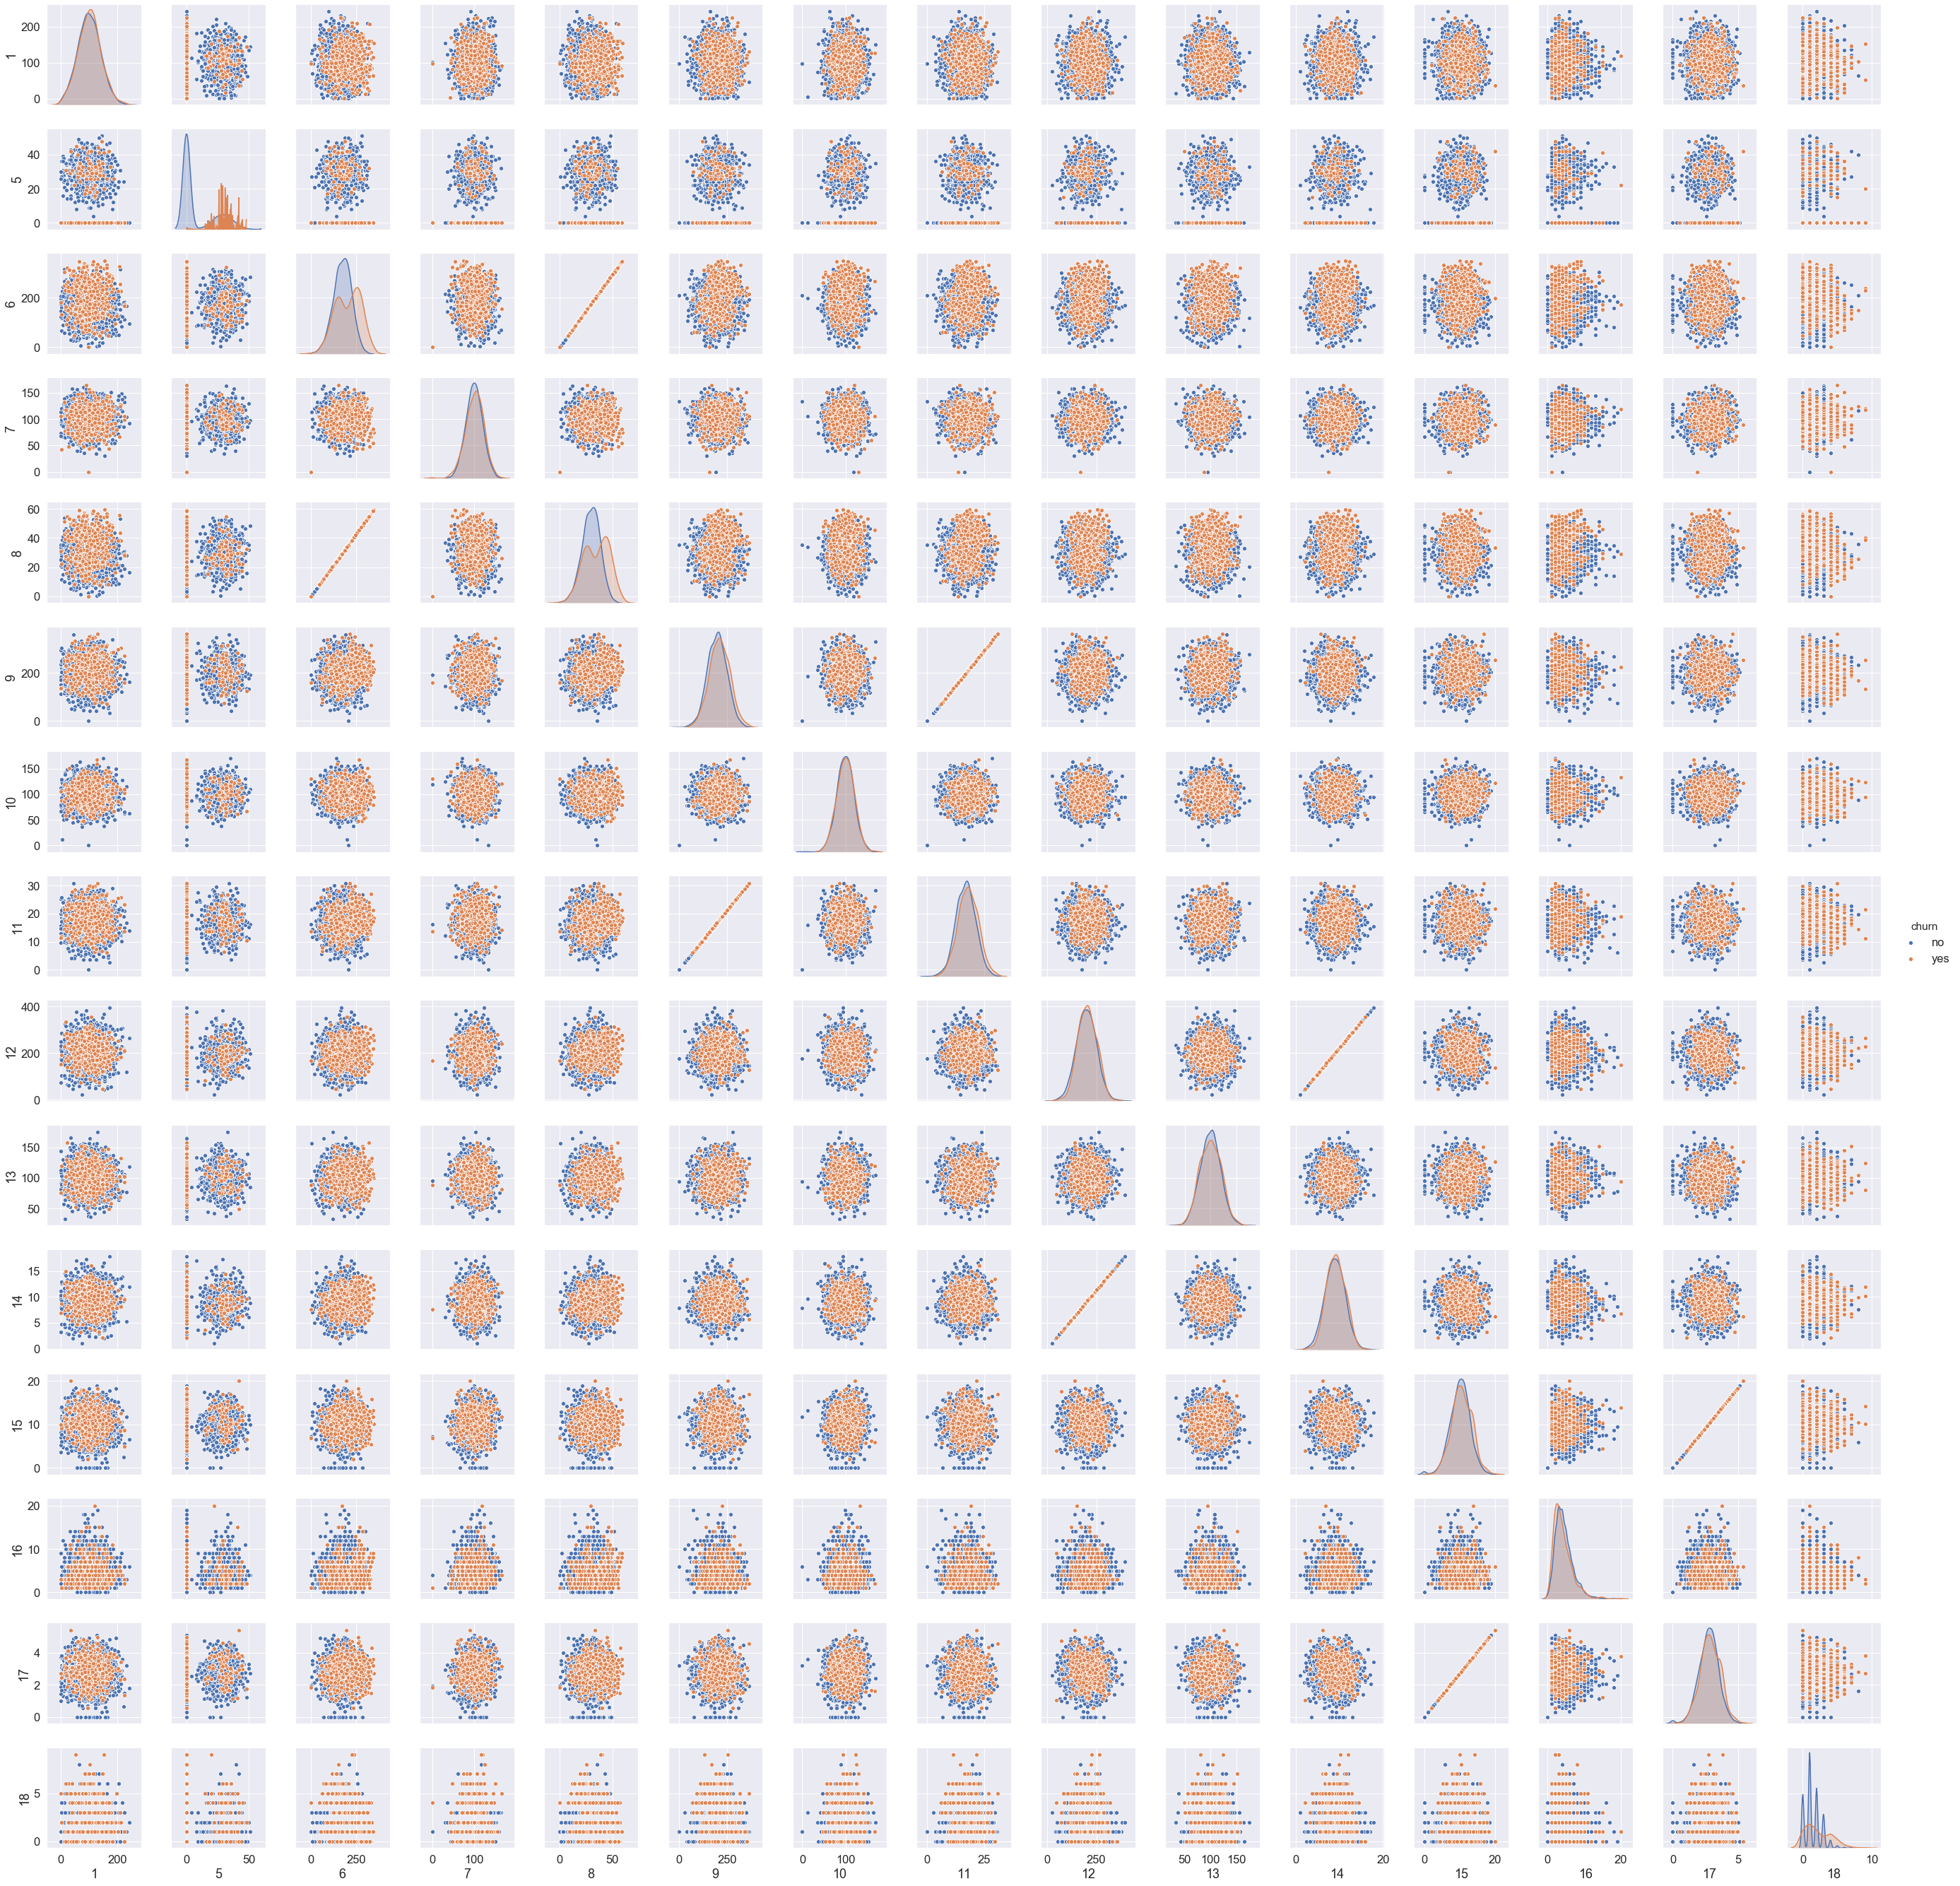

In [22]:
#Usando a função pairs do pacote seaborn para dar uma olhada na distribuição das variáveis numéricas
sns.set(font_scale=1.5)
sns.pairplot(dados.loc['treino'].rename(columns = mapeamento),hue = 'churn')

É notavel, tanto pelo gráfico de dispersão, tanto pelo mapa de correlação (agora ainda mais evidente) que existe uma dependencia linear entre algumas variáveis, sempre respeitando:

__**_charge*__ e __**_minutes*__

Por isso, <font color = blue> podemos remover um dos pares </font>, para faciliar a modelagem e não permitir dependência linear entre elas

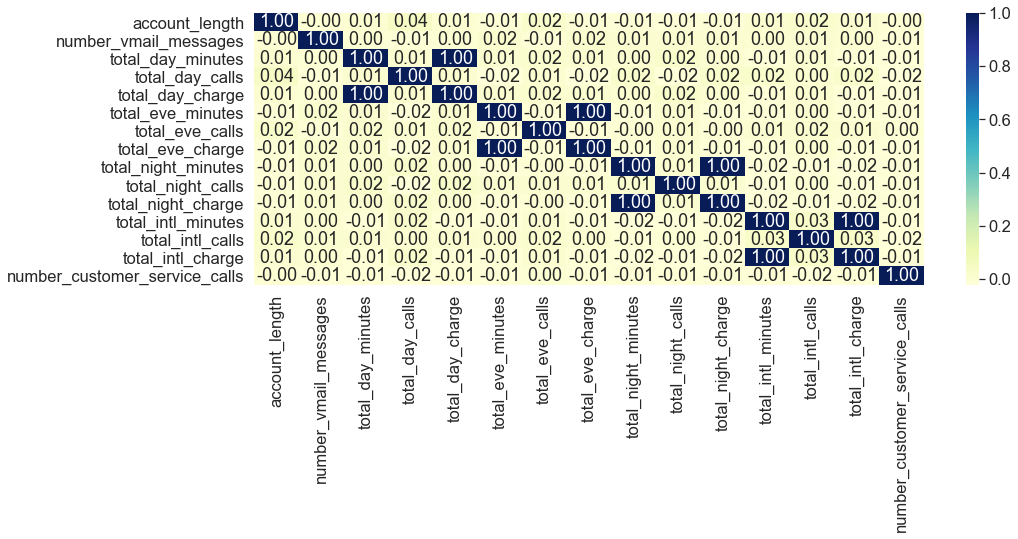

In [23]:
#Analisando a correlação entre as variáveis
plt.subplots(figsize=(15,5))
sns.heatmap(dados.loc['treino'].corr(), annot=True, fmt=".2f",cmap="YlGnBu")

Vamos verificar se existe algum comportamento relevante em um barplot, quando olhamos cada estado

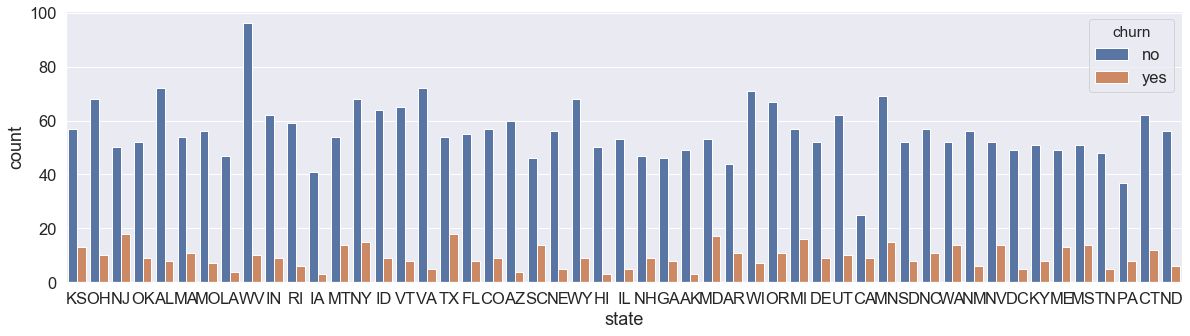

In [24]:
figsize=(20,5)
plt.subplots(figsize=figsize)
sns.countplot(x = 'state',data=dados.loc['treino'],hue = 'churn')

Vamos verificar se, a partir de boxplot, conseguimos verificar alguma informação por estado

In [25]:
#Definindo uma função bloxplot, para mostrar a situação das variáveis por estado
def boxplot_state(xy,dataset,hue,figsize):
    plt.subplots(figsize=figsize)
    sns.boxenplot(x=xy[0],y=xy[1],data=dataset,hue = hue)

In [27]:
#Encontrando quem sao as variáveis categóricas e numéricas
categoricas = explore_describe(dados.loc['treino'])['variable'][explore_describe(dados.loc['treino'])['type'].\
                                         map(lambda x: True if ('object' in str(x)) else False)]
categoricas = categoricas[categoricas != 'churn'].to_list()

numericas = explore_describe(dados.loc['treino'])['variable'][explore_describe(dados.loc['treino'])['type'].\
                                         map(lambda x: True if (('int' in str(x)) or ('float' in str(x))) else False)].to_list()


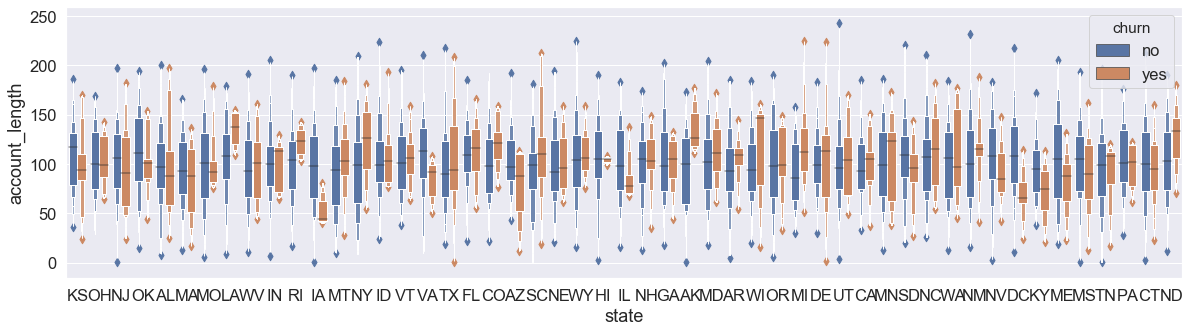

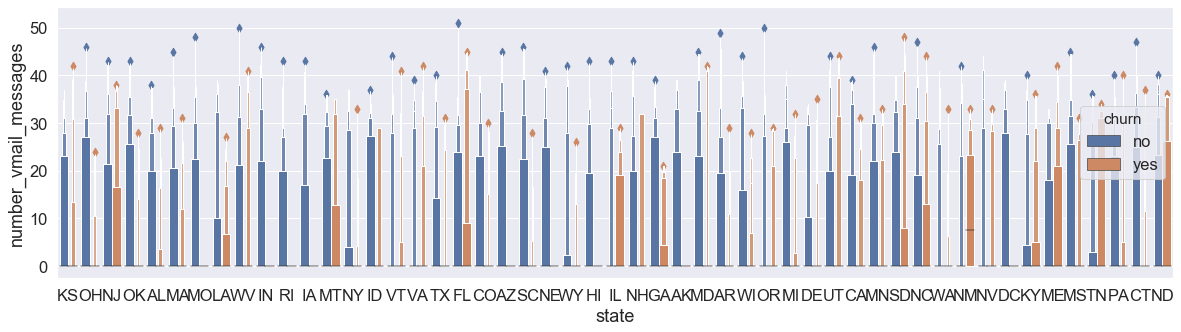

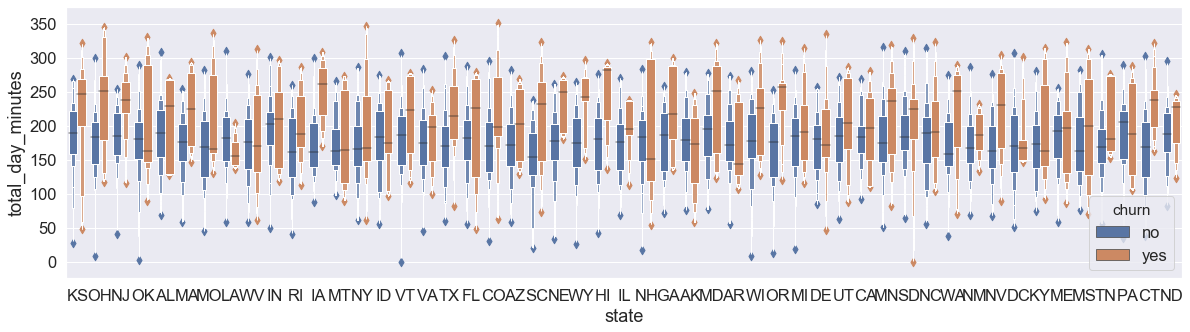

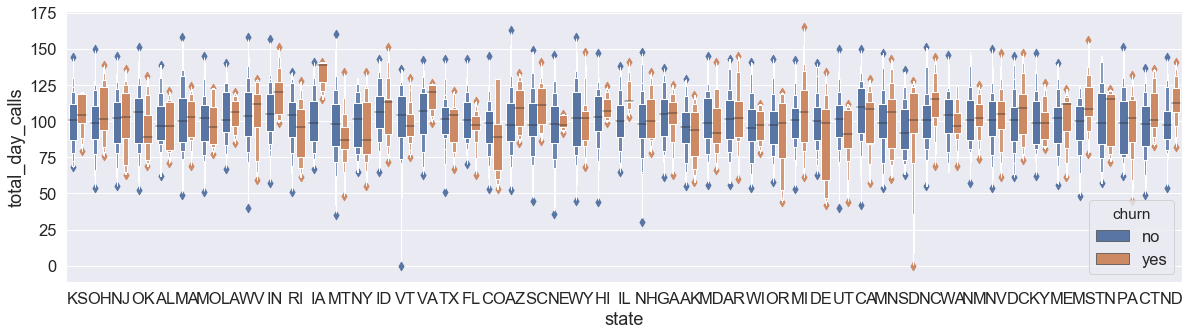

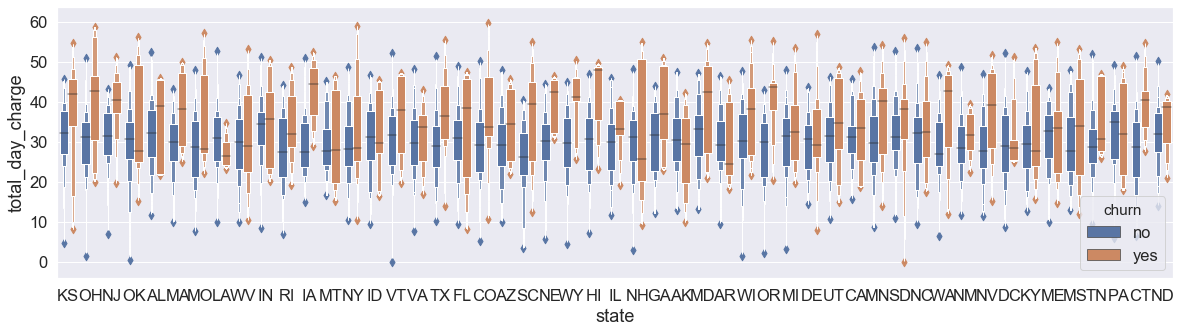

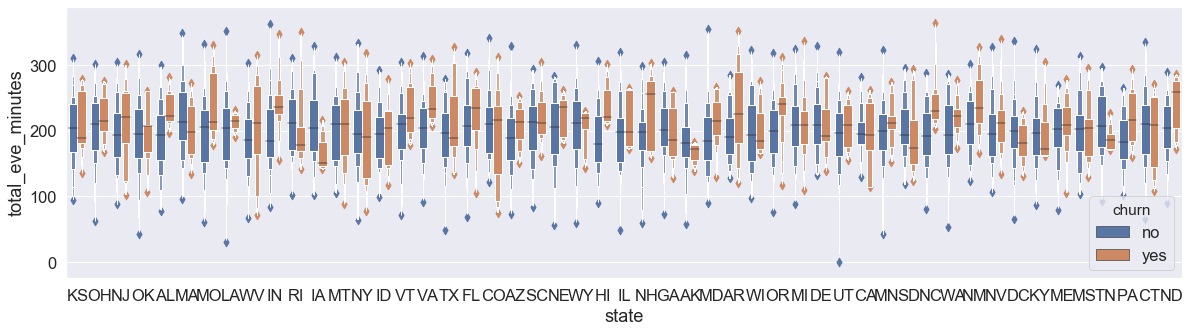

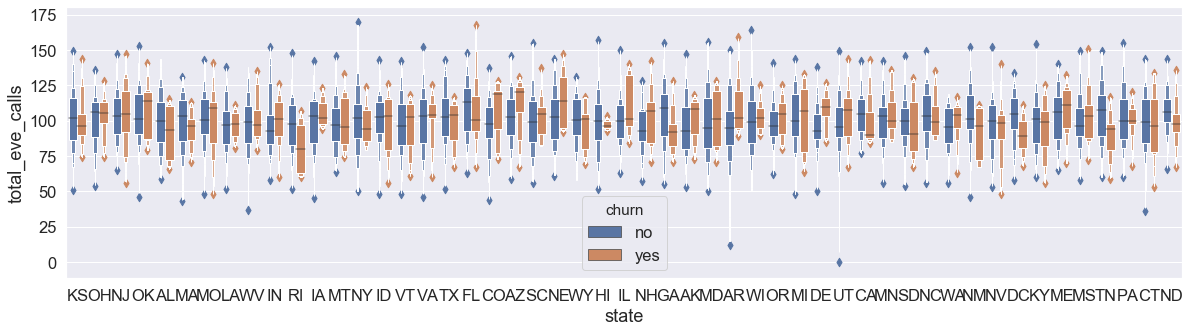

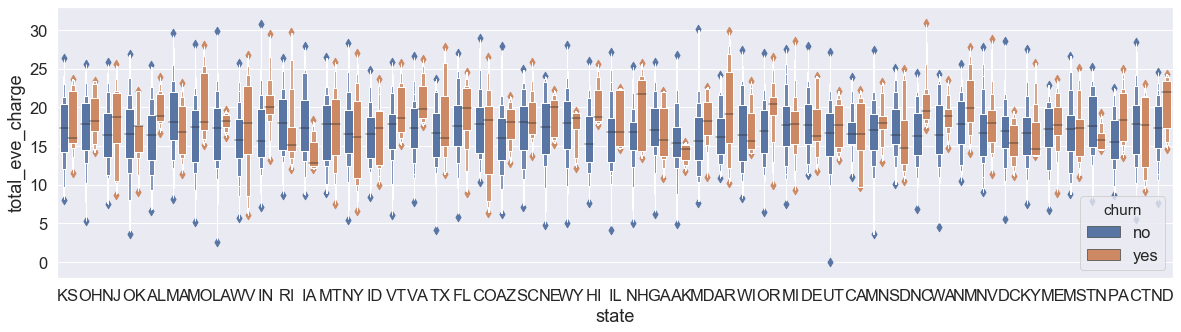

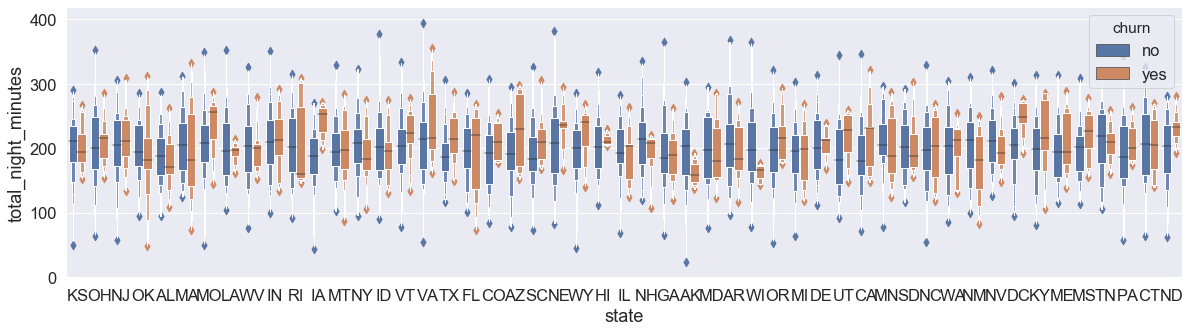

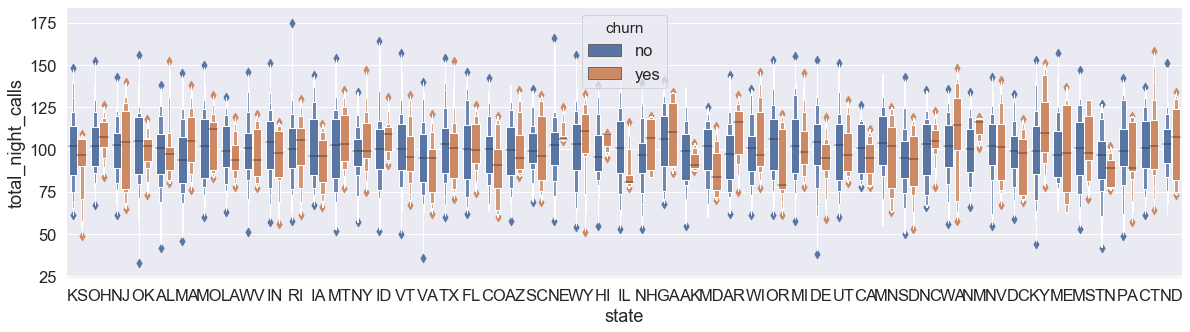

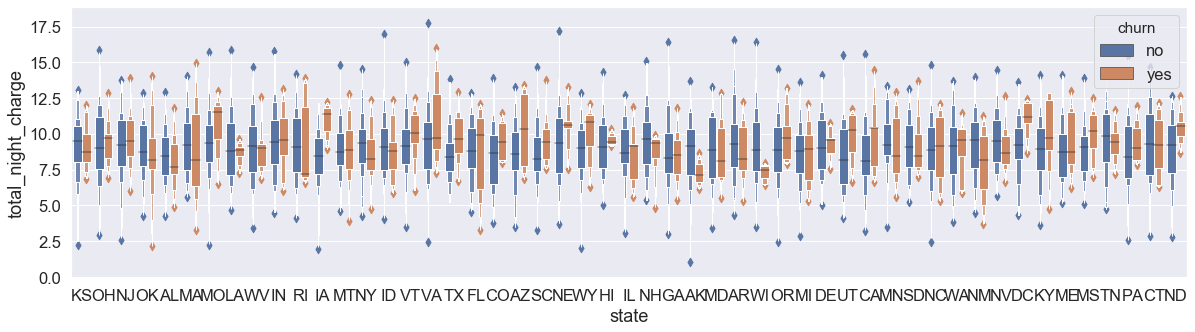

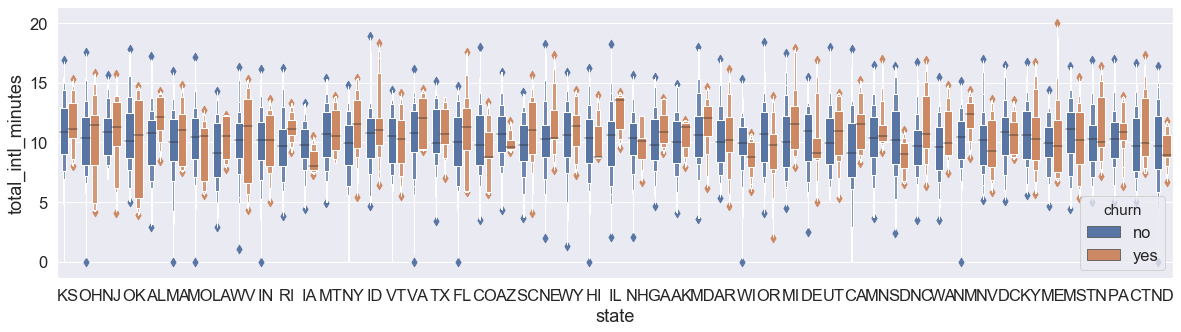

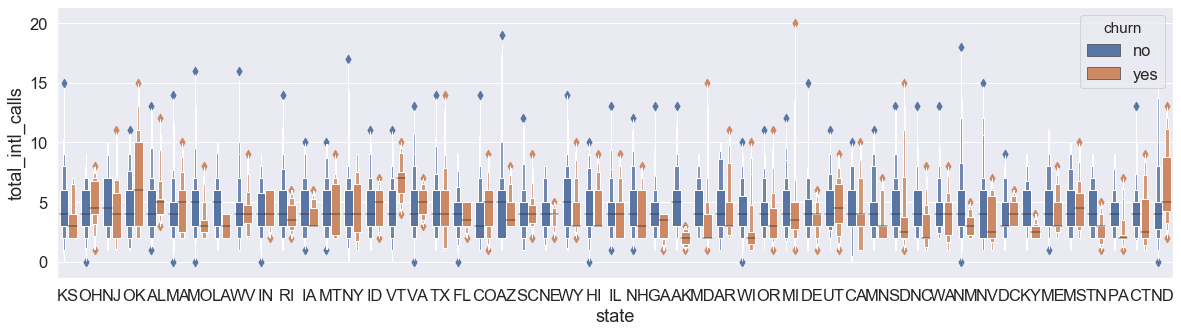

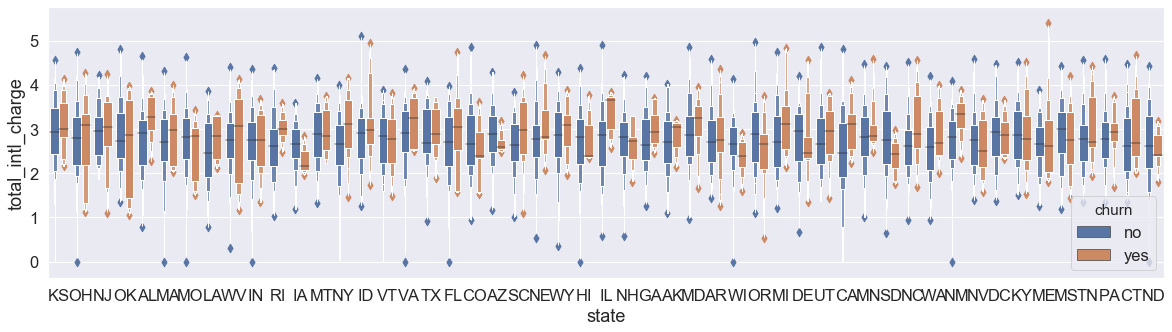

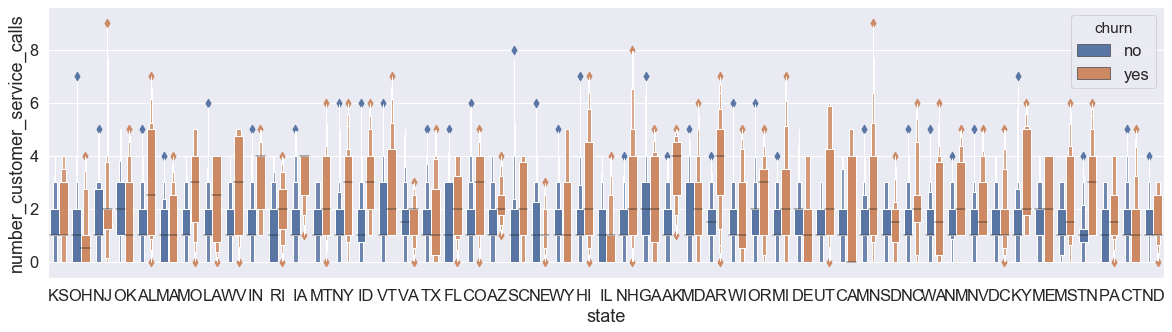

In [30]:
for xy in list(product(['state'],numericas)):
    boxplot_state(xy,dados.loc['treino'],'churn',(20,5))

In [31]:
#Verificando as deis variáveis
categoricas_sem_state = list(filter(lambda x: True if x != 'state' else False,categoricas))

A variância existente para *number_customer_service_calls* é bem maior quando o *churn* é positivo, do que quando o churn é negativo;

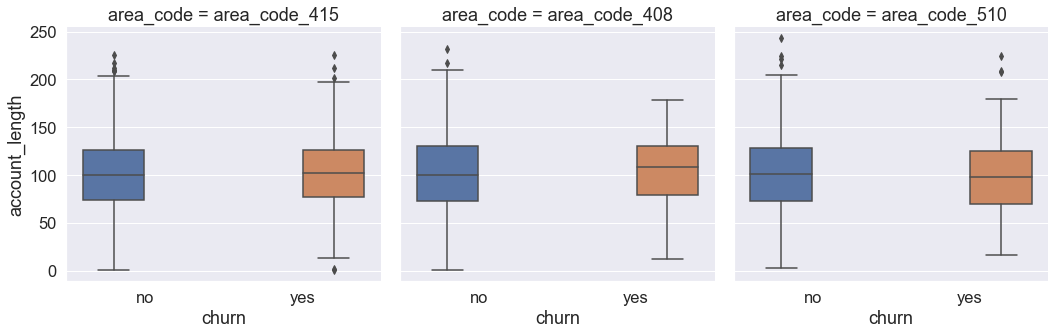

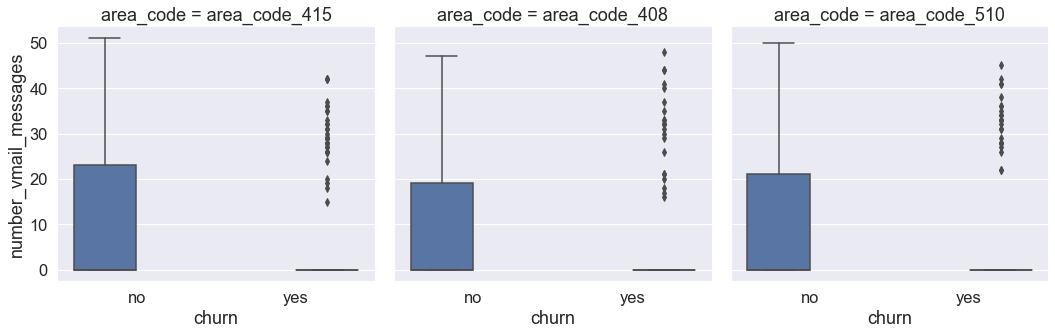

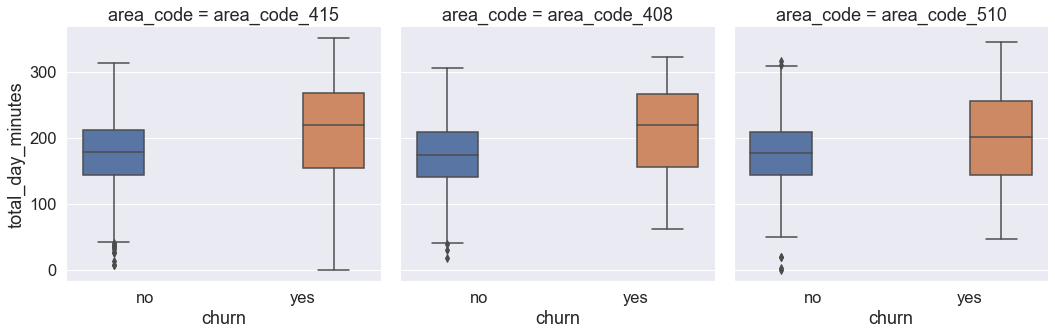

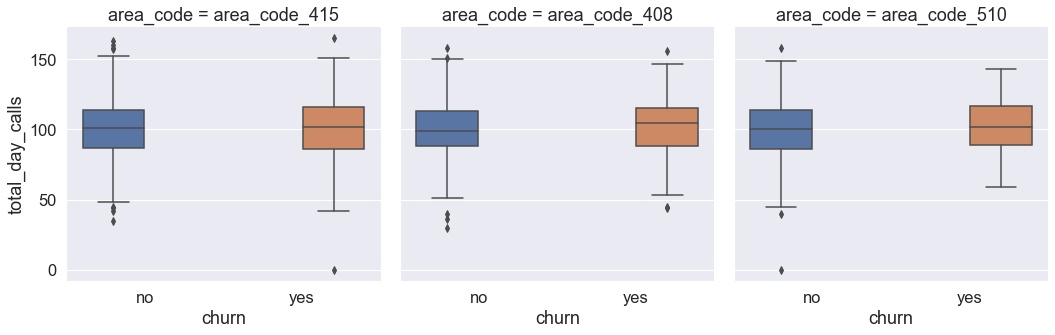

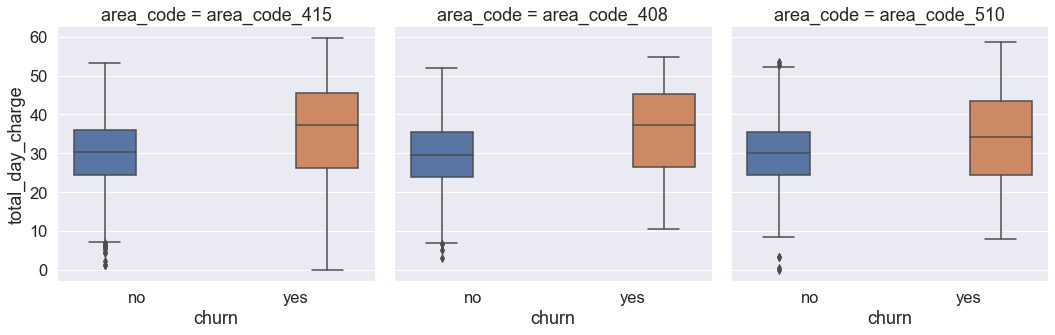

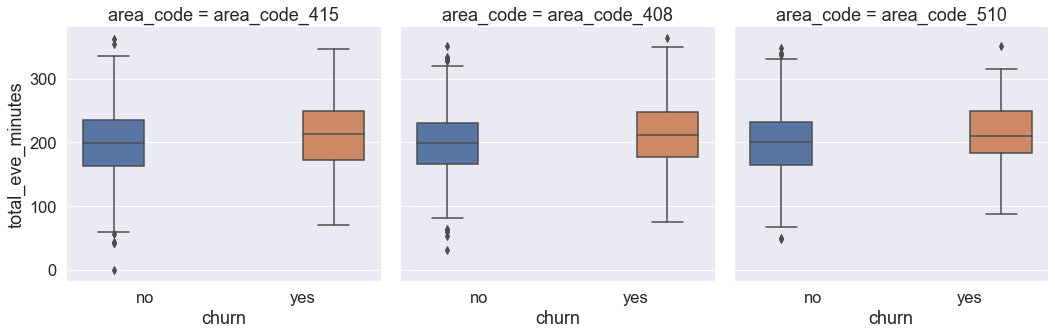

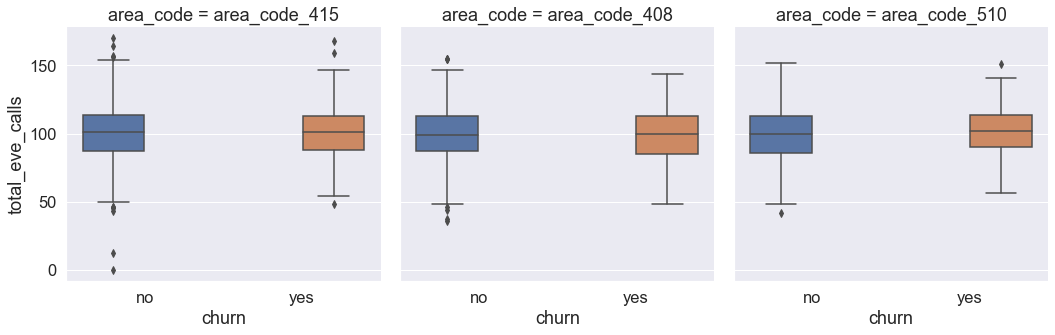

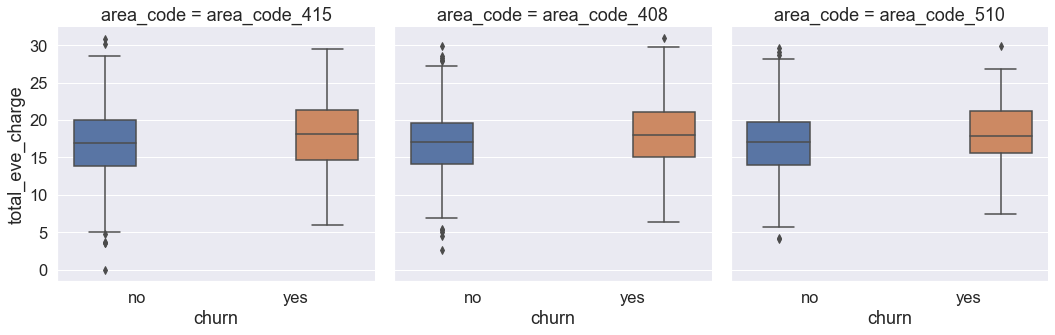

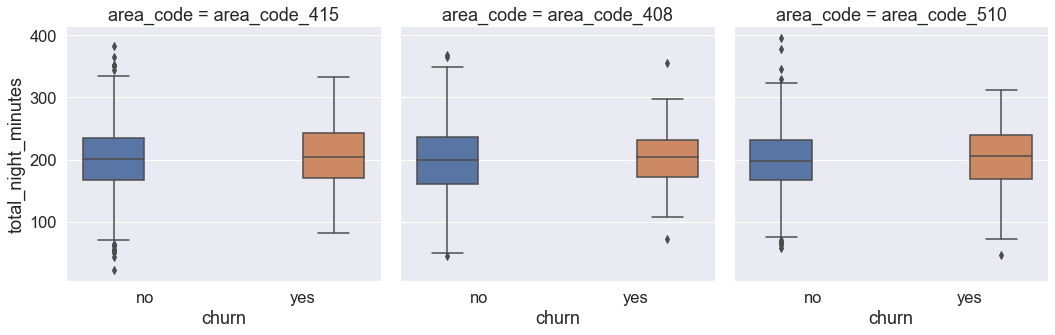

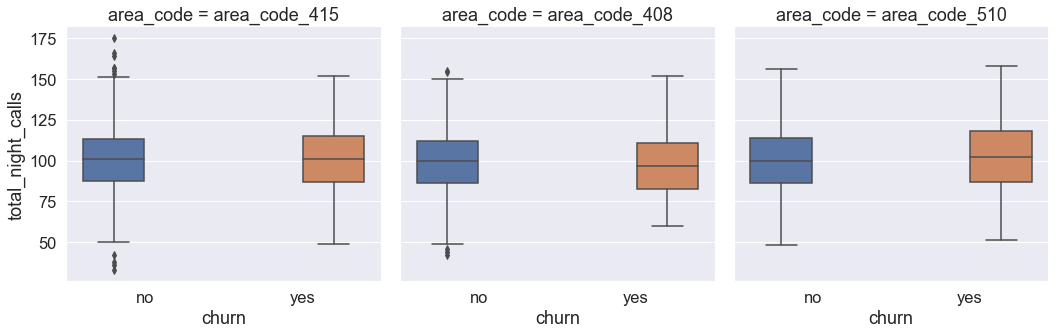

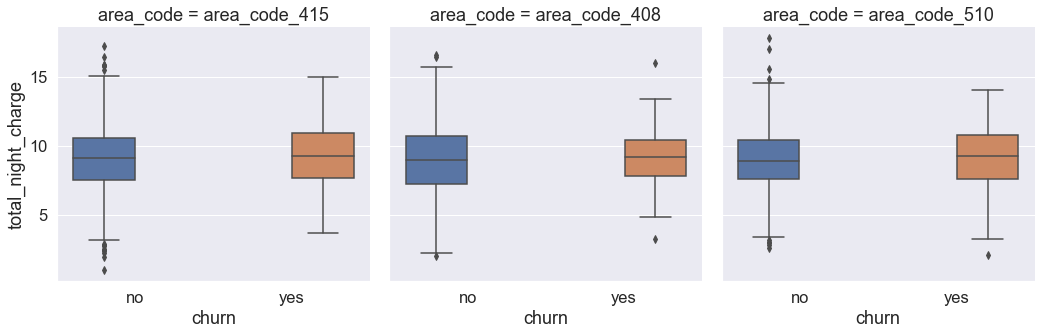

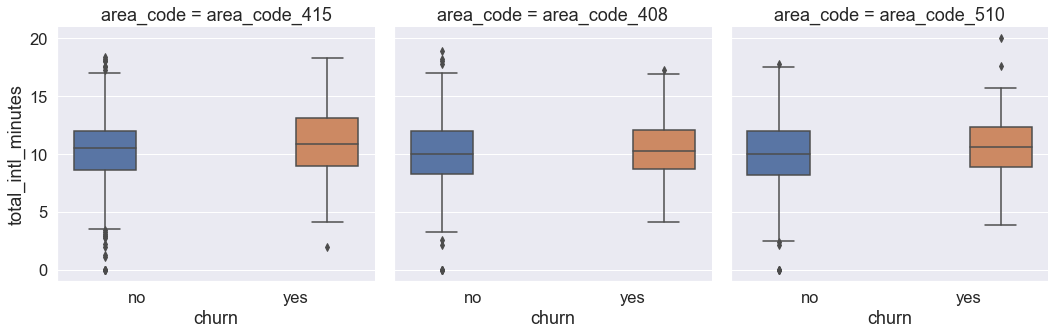

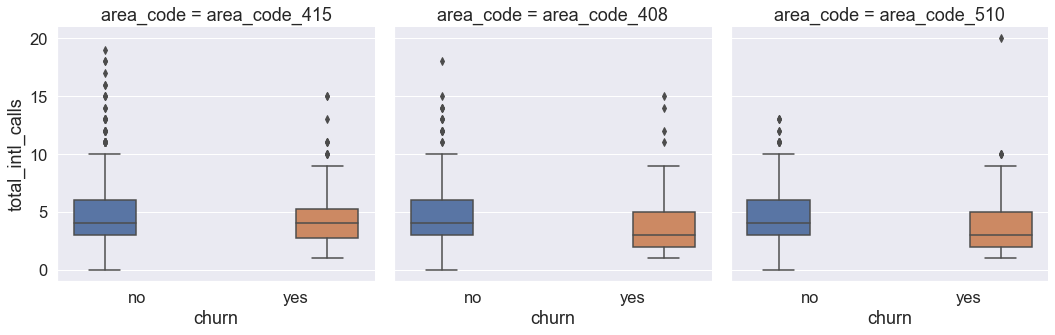

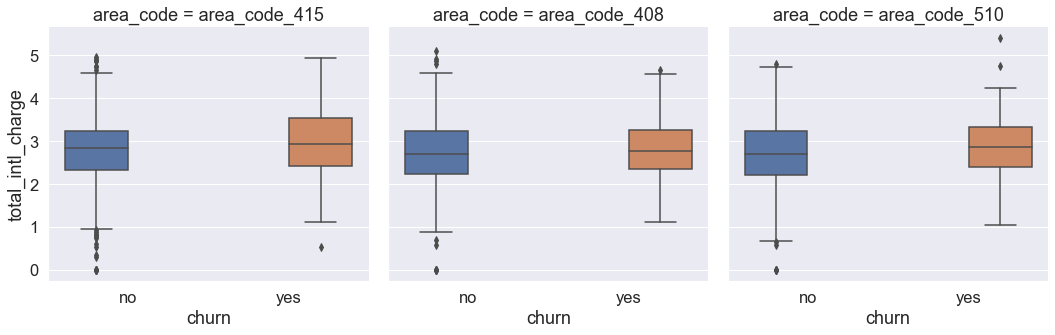

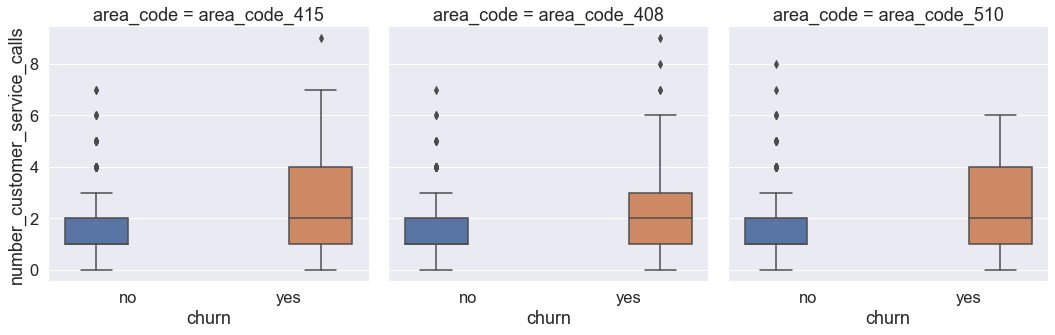

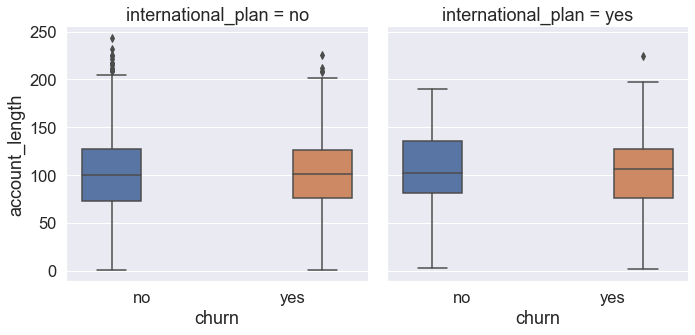

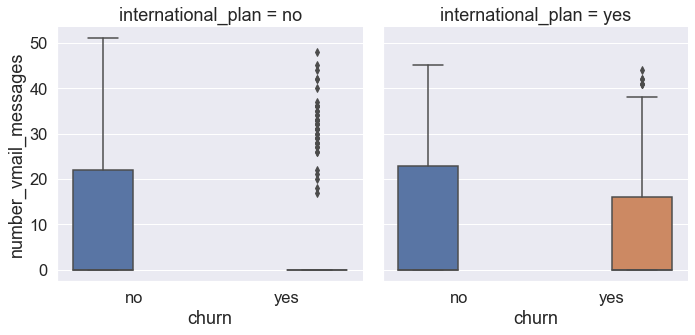

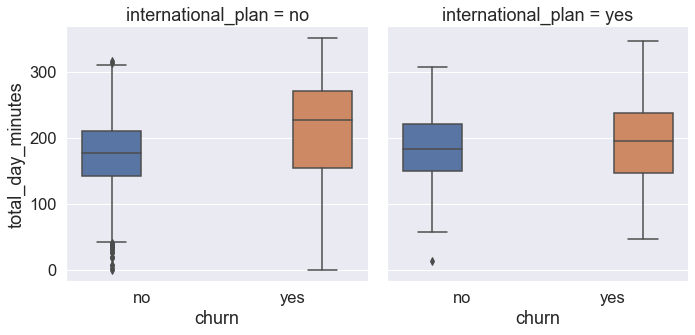

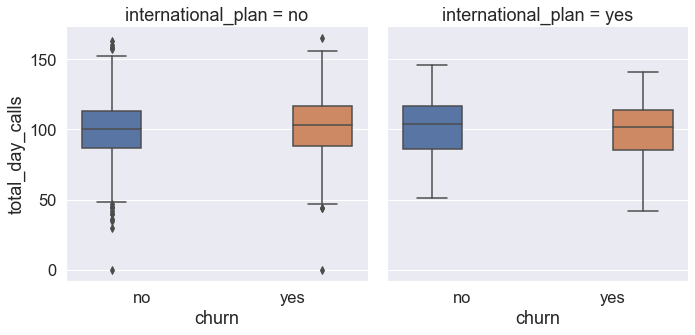

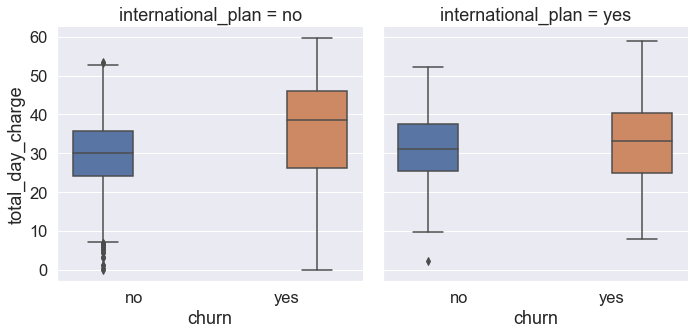

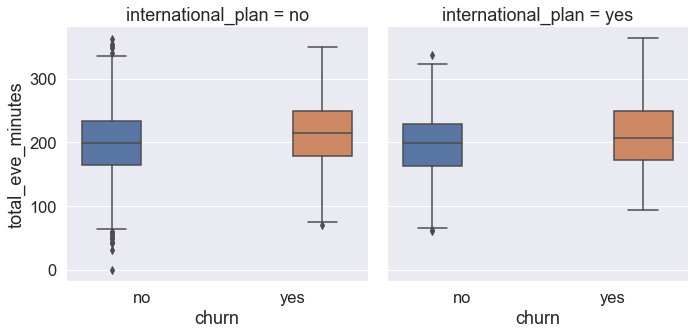

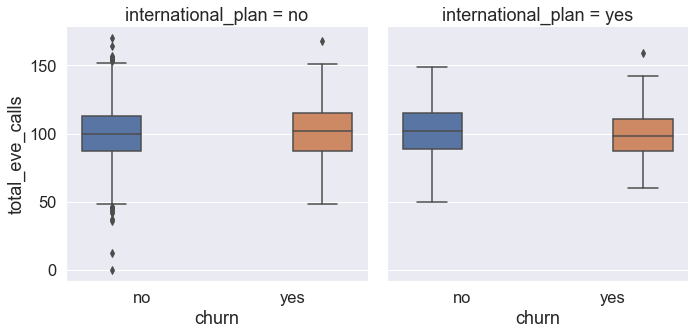

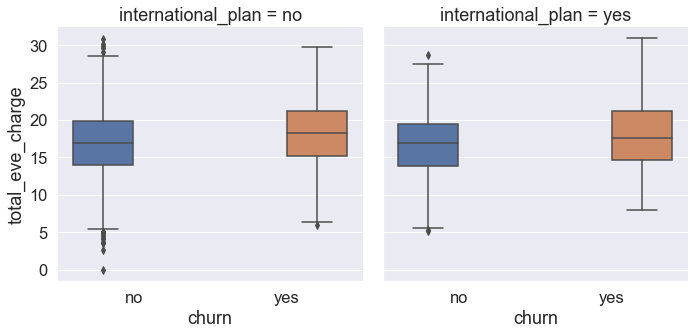

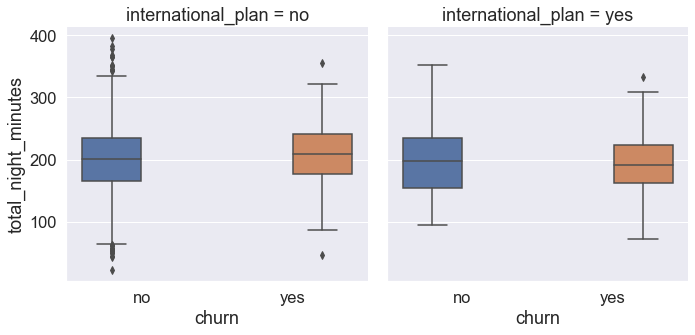

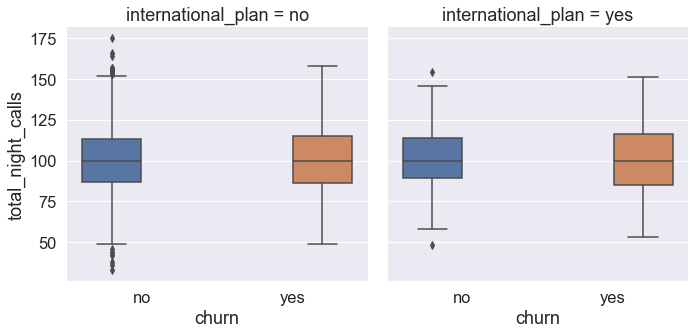

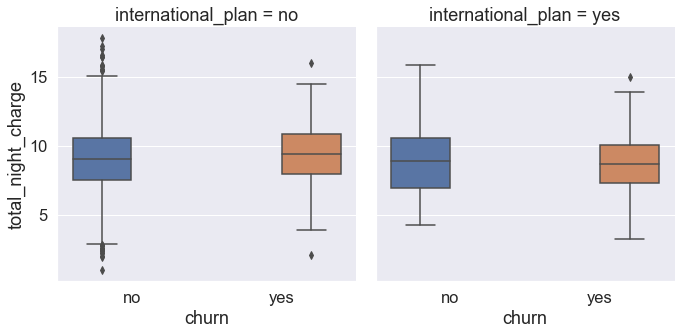

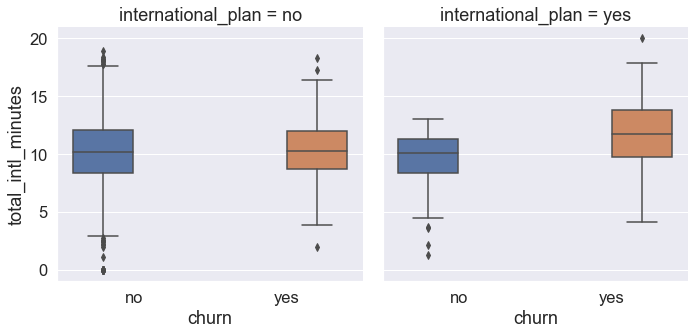

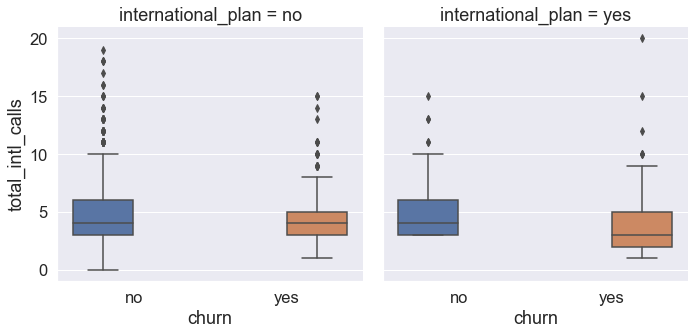

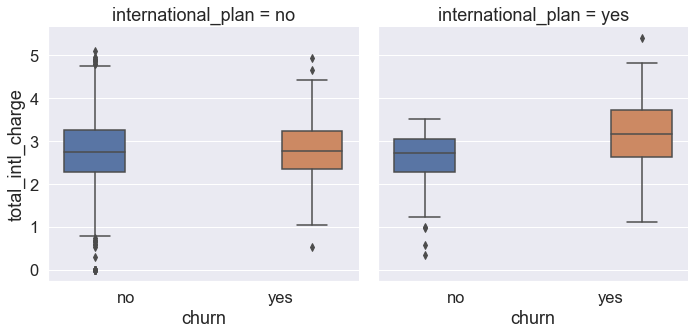

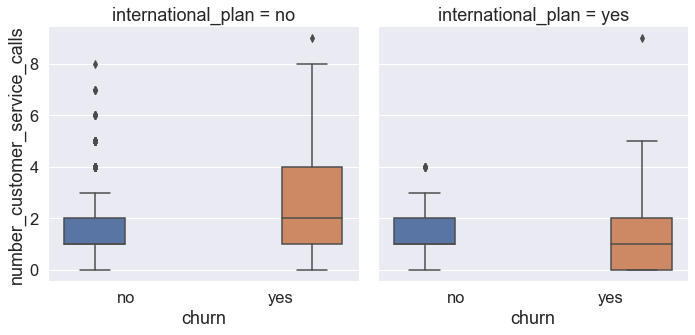

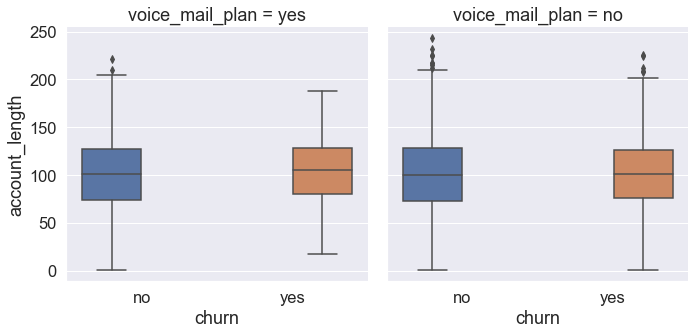

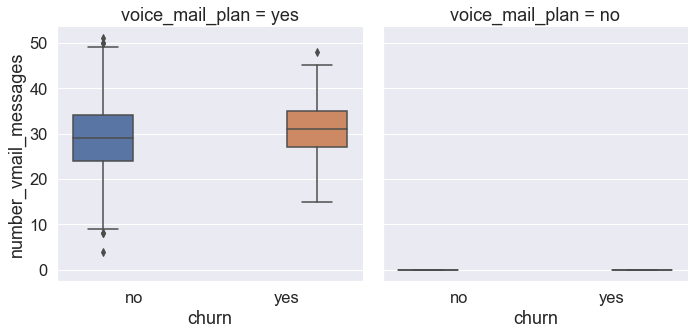

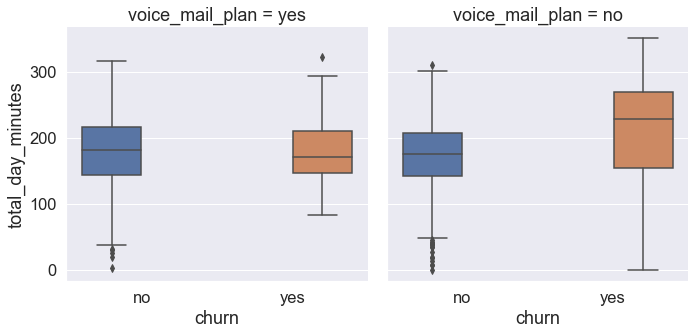

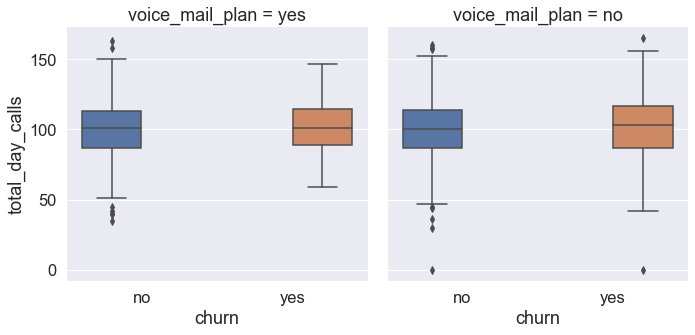

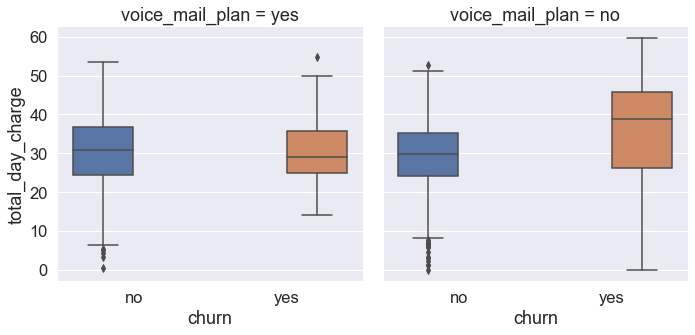

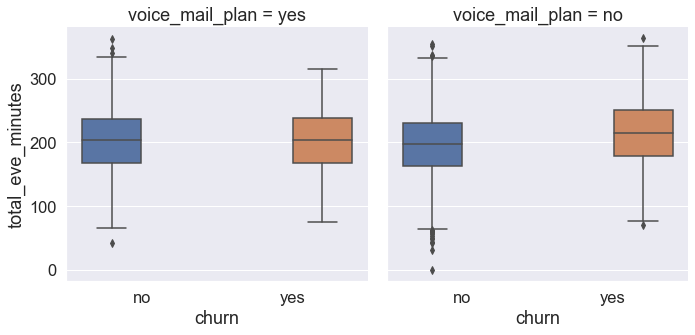

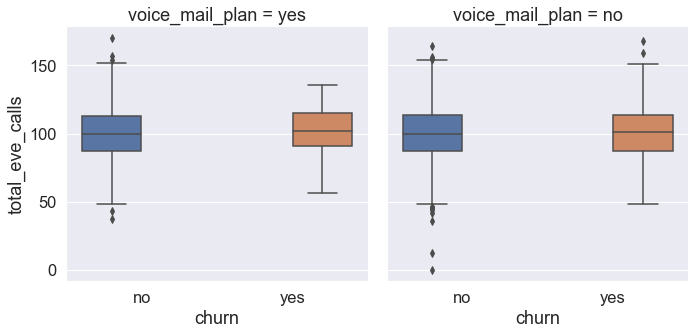

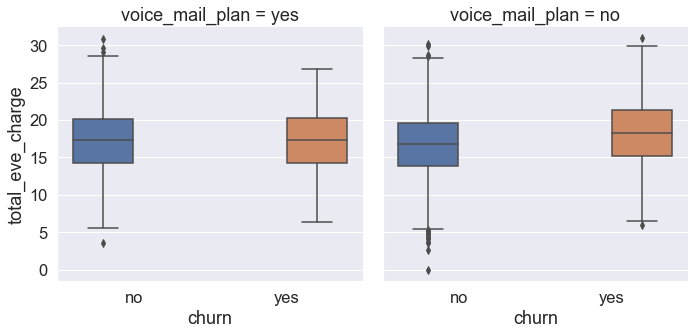

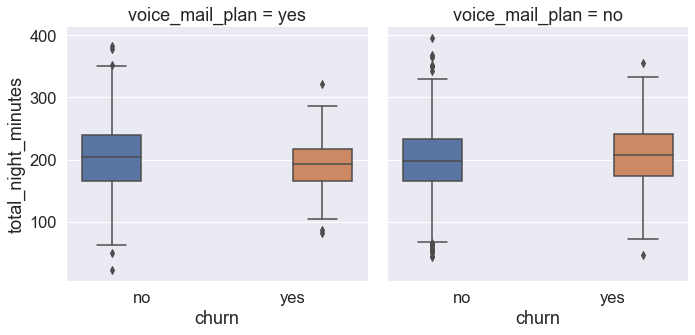

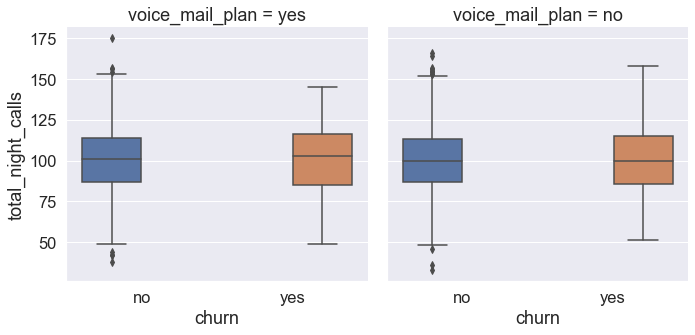

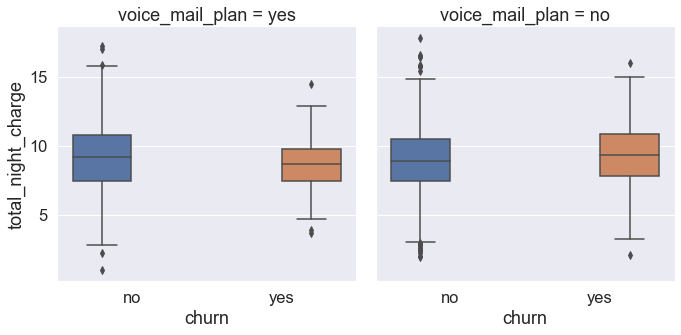

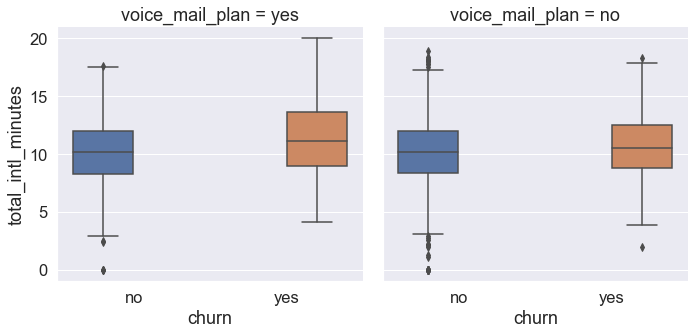

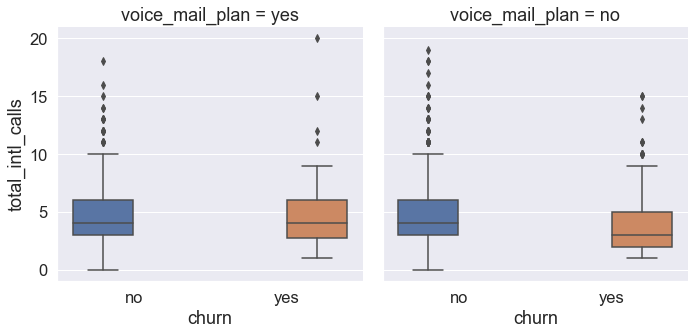

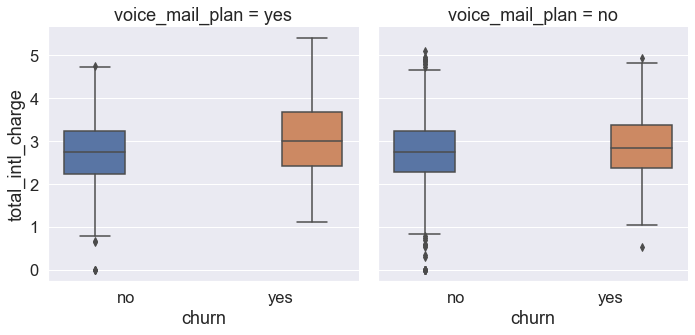

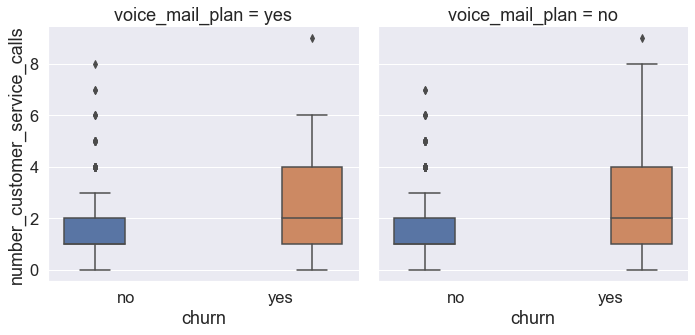

In [33]:
for xy in product(categoricas_sem_state,numericas):
    sns.catplot(col = xy[0], x = 'churn',y = xy[1], hue = "churn", data=dados.loc['treino'], kind="box")

Para cada uma das variáveis categóricas, vamos ver como está a relação do *churn*
- Nota-se que, para o caso de não haver pacote internacional, o *churn* negativo é bem maior que o *churn* positivo. Dessa forma, pode ser uma hipótese que não ter o pacote internacional, 

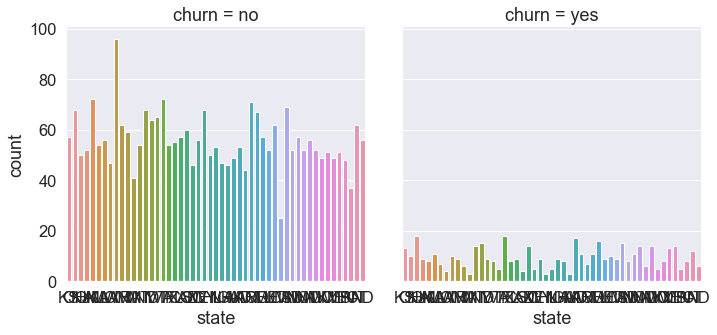

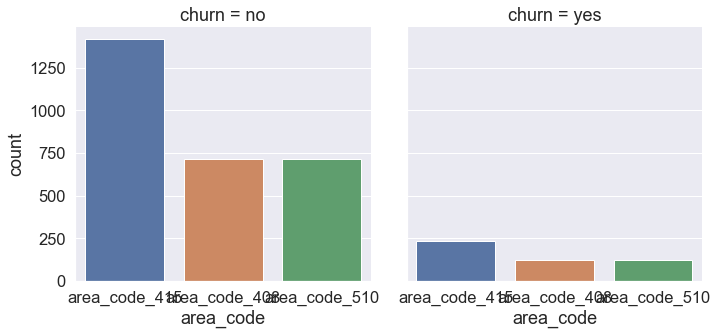

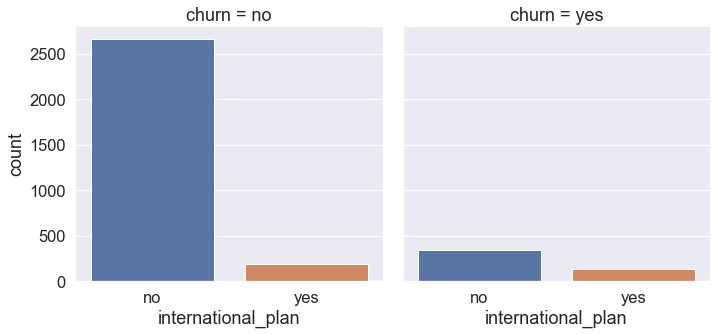

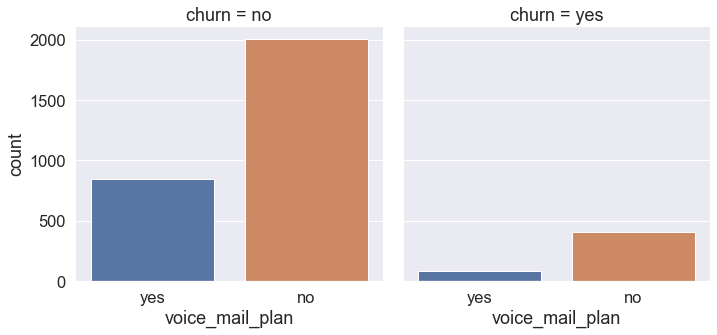

In [34]:
for cat in categoricas:
    sns.catplot(cat, col = 'churn', data =dados.loc['treino'], kind = 'count')

In [35]:
#Verificando o estado com o maior número de clientes e seus tipos. 
grup_state_churn = dados.loc['treino'].groupby(['state','churn'])[['voice_mail_plan']].count().reset_index(level = ('state','churn'))
pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).\
assign(total = pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).no+\
       pd.crosstab(grup_state_churn.state, columns=grup_state_churn.churn, values = grup_state_churn.voice_mail_plan,aggfunc = sum).yes).\
sort_values(by=['total'],ascending=False)

churn  no  yes  total
state                
WV     96   10    106
MN     69   15     84
NY     68   15     83
AL     72    8     80
OR     67   11     78
WI     71    7     78
OH     68   10     78
VA     72    5     77
WY     68    9     77
CT     62   12     74
VT     65    8     73
ID     64    9     73
MI     57   16     73
UT     62   10     72
TX     54   18     72
IN     62    9     71
KS     57   13     70
MD     53   17     70
NJ     50   18     68
NC     57   11     68
MT     54   14     68
CO     57    9     66
NV     52   14     66
WA     52   14     66
RI     59    6     65
MS     51   14     65
MA     54   11     65
AZ     60    4     64
MO     56    7     63
FL     55    8     63
ND     56    6     62
ME     49   13     62
NM     56    6     62
OK     52    9     61
NE     56    5     61
DE     52    9     61
SC     46   14     60
SD     52    8     60
KY     51    8     59
IL     53    5     58
NH     47    9     56
AR     44   11     55
DC     49    5     54
GA     46    8     54
HI     50    3     53
TN     48    5     53
AK     49    3     52
LA     47    4     51
PA     37    8     45
IA     41    3     44
CA     25    9     34

## Transformação de variáveis

Vamos criar algumas classes que possuem funções de conversões

In [2]:
#Convertendo as variáveis booleanas
class conversor_bool():
    def __init__(self,colunas = ['international_plan','voice_mail_plan']):
        self.colunas = colunas
    def fit(self,X,y = None):
        return self
    def transform(self,X):
        X_retorno = X.copy()
        X_retorno[self.colunas] = X_retorno[self.colunas].replace({'yes':True,'no':False})
        return X_retorno
    
class add_count_columns():
    def __init__(self, colunas):
        self.colunas = colunas
        self.cada = pd.Series([])
        self.dupla = pd.Series([])
        self.tripla = pd.Series([])
    def fit(self,X,y=None):
        for cada in self.colunas:
            Qtde_elem_coluna = X.groupby(cada)[cada].count()
            procv_atual = pd.Series(Qtde_elem_coluna.values,index=[(cada,i) for i in Qtde_elem_coluna.index])
            self.cada=self.cada.append(procv_atual)
        self.cada = self.cada.reindex(pd.MultiIndex.from_tuples(self.cada.index))
        for dupla in list(combinations(self.colunas,2)):
            Qtde_elem_coluna = X.groupby(list(dupla))[dupla[0]].count()
            self.dupla=self.dupla.append(pd.Series(Qtde_elem_coluna.values,index = [tuple(list(dupla)+list(i)) for i in Qtde_elem_coluna.index]))
        self.dupla = self.dupla.reindex(pd.MultiIndex.from_tuples(self.dupla.index))
        for tripla in list(combinations(self.colunas,3)):
            Qtde_elem_coluna = X.groupby(list(tripla))[tripla[0]].count()
            self.tripla=self.tripla.append(pd.Series(Qtde_elem_coluna.values,index = [tuple(list(tripla)+list(i)) for i in Qtde_elem_coluna.index]))
        self.tripla = self.tripla.reindex(pd.MultiIndex.from_tuples(self.tripla.index))
        return self
    def transform(self,X):
        X_retorno = X.copy()
        for cada in list(self.cada.index):
            X_retorno.loc[X_retorno[cada[0]]==cada[1],"".join((cada[0],"_N"))] = self.cada[cada]
        for dupla in list(self.dupla.index):
            X_retorno.loc[(X_retorno[dupla[0]]==dupla[2]) & (X_retorno[dupla[1]]==dupla[3]),"_".join(("_".join((dupla[0],dupla[1])),"N"))]= self.dupla[dupla]
        for tripla in list(self.tripla.index):
            X_retorno.loc[(X_retorno[tripla[0]]==tripla[3]) & 
                          (X_retorno[tripla[1]]==tripla[4]) &
                          (X_retorno[tripla[2]]==tripla[5]),"_".join(("_".join((tripla[0],
                                                                                tripla[1],
                                                                                tripla[2],)),"N"))]= self.tripla[tripla]
        return X_retorno
    def fit_transform(self,X,y=None):
        return self.fit(X).transform(X)
    
#Classe que elimina variáveis categoricas que nao serão mais utilizadas    
class drop_all_columns():
    def __init__(self,colunas = ['state','area_code','total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']):
        self.colunas = colunas
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_retorno = X.copy()
        return X_retorno.drop(columns = self.colunas)

    
class outliers():
    def __init__(self,colunas_variaveis):
        self.colunas = colunas_variaveis
        self.desvio = {}
        self.media = {}
    def fit(self,X,y = None):
        for cada_coluna in self.colunas:
            self.desvio.update({cada_coluna:X[cada_coluna].std()})
            self.media.update({cada_coluna:X[cada_coluna].mean()})
        return self
    def transform(self,X):
        X_return = X.copy()
        for cada_coluna in self.colunas:
            X_return.loc[(X_return[cada_coluna] >= self.media[cada_coluna] + 3*self.desvio[cada_coluna]) | \
                     (X_return[cada_coluna] <= self.media[cada_coluna] -3*self.desvio[cada_coluna]),cada_coluna] = self.media[cada_coluna]
        return X_return

In [72]:
#Vamos alterar as colunas booleanas
colunas_booleanas = ['international_plan','churn','voice_mail_plan']
dados = conversor_bool(colunas_booleanas).transform(dados)
dados

state  account_length      area_code  international_plan  \
tipo_dado index                                                            
treino    0        KS             128  area_code_415               False   
          1        OH             107  area_code_415               False   
          2        NJ             137  area_code_415               False   
          3        OH              84  area_code_408                True   
          4        OK              75  area_code_415                True   
...               ...             ...            ...                 ...   
teste     1662     HI              50  area_code_408               False   
          1663     WV             152  area_code_415               False   
          1664     DC              61  area_code_415               False   
          1665     DC             109  area_code_510               False   
          1666     VT              86  area_code_415               False   

                 voice_mail_plan  number_vmail_messages  total_day_minutes  \
tipo_dado index                                                              
treino    0                 True                     25              265.1   
          1                 True                     26              161.6   
          2                False                      0              243.4   
          3                False                      0              299.4   
          4                False                      0              166.7   
...                          ...                    ...                ...   
teste     1662              True                     40              235.7   
          1663             False                      0              184.2   
          1664             False                      0              140.6   
          1665             False                      0              188.8   
          1666              True                     34              129.4   

                 total_day_calls  total_day_charge  total_eve_minutes  \
tipo_dado index                                                         
treino    0                  110             45.07              197.4   
          1                  123             27.47              195.5   
          2                  114             41.38              121.2   
          3                   71             50.90               61.9   
          4                  113             28.34              148.3   
...                          ...               ...                ...   
teste     1662               127             40.07              223.0   
          1663                90             31.31              256.8   
          1664                89             23.90              172.8   
          1665                67             32.10              171.7   
          1666               102             22.00              267.1   

                 total_eve_calls  total_eve_charge  total_night_minutes  \
tipo_dado index                                                           
treino    0                   99             16.78                244.7   
          1                  103             16.62                254.4   
          2                  110             10.30                162.6   
          3                   88              5.26                196.9   
          4                  122             12.61                186.9   
...                          ...               ...                  ...   
teste     1662               126             18.96                297.5   
          1663                73             21.83                213.6   
          1664               128             14.69                212.4   
          1665                92             14.59                224.4   
          1666               104             22.70                154.8   

                 total_night_calls  total_night_charge  total_intl_minutes  \
tipo_dad

In [73]:
#Adicionar novas variáveis ao dataset, sendo elas as contagens de aparições
count_columns=add_count_columns(categoricas).fit(dados)
dados = count_columns.transform(dados)
dados

state  account_length      area_code  international_plan  \
tipo_dado index                                                            
treino    0        KS             128  area_code_415               False   
          1        OH             107  area_code_415               False   
          2        NJ             137  area_code_415               False   
          3        OH              84  area_code_408                True   
          4        OK              75  area_code_415                True   
...               ...             ...            ...                 ...   
teste     1662     HI              50  area_code_408               False   
          1663     WV             152  area_code_415               False   
          1664     DC              61  area_code_415               False   
          1665     DC             109  area_code_510               False   
          1666     VT              86  area_code_415               False   

                 voice_mail_plan  number_vmail_messages  total_day_minutes  \
tipo_dado index                                                              
treino    0                 True                     25              265.1   
          1                 True                     26              161.6   
          2                False                      0              243.4   
          3                False                      0              299.4   
          4                False                      0              166.7   
...                          ...                    ...                ...   
teste     1662              True                     40              235.7   
          1663             False                      0              184.2   
          1664             False                      0              140.6   
          1665             False                      0              188.8   
          1666              True                     34              129.4   

                 total_day_calls  total_day_charge  total_eve_minutes  ...  \
tipo_dado index                                                        ...   
treino    0                  110             45.07              197.4  ...   
          1                  123             27.47              195.5  ...   
          2                  114             41.38              121.2  ...   
          3                   71             50.90               61.9  ...   
          4                  113             28.34              148.3  ...   
...                          ...               ...                ...  ...   
teste     1662               127             40.07              223.0  ...   
          1663                90             31.31              256.8  ...   
          1664                89             23.90              172.8  ...   
          1665                67             32.10              171.7  ...   
          1666               102             22.00              267.1  ...   

                 state_area_code_N  state_international_plan_N  \
tipo_dado index                                                  
treino    0                   50.0                        87.0   
          1                   61.0                       104.0   
          2                   58.0                       100.0   
          3                   29.0                        12.0   
          4                   38.0                         9.0   
...                            ...                         ...   
teste     1662                24.0                        80.0   
          1663                73.0                       147.0   
          1664                45.0                        78.0   
          1665                23.0                        78.0   
          1666                50.0                        92.0   

                 state_voice_mail_plan_N  area_code_international_plan_N  \
tipo_dado index                                               

In [74]:
#Salvando os parametros obtidos do fit da contagem de elementos
pickle.dump(count_columns,open('contagem/contagem.sav','wb'))

In [75]:
#Por fim, removendo as colunas que nao serão mais utilizadas (linearmente dependente com outras variáveis)
colunas_remover = ['state','area_code','total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']
dados = drop_all_columns(colunas_remover).transform(dados)
dados

account_length  international_plan  voice_mail_plan  \
tipo_dado index                                                        
treino    0                 128               False             True   
          1                 107               False             True   
          2                 137               False            False   
          3                  84                True            False   
          4                  75                True            False   
...                         ...                 ...              ...   
teste     1662               50               False             True   
          1663              152               False            False   
          1664               61               False            False   
          1665              109               False            False   
          1666               86               False             True   

                 number_vmail_messages  total_day_minutes  total_day_calls  \
tipo_dado index                                                              
treino    0                         25              265.1              110   
          1                         26              161.6              123   
          2                          0              243.4              114   
          3                          0              299.4               71   
          4                          0              166.7              113   
...                                ...                ...              ...   
teste     1662                      40              235.7              127   
          1663                       0              184.2               90   
          1664                       0              140.6               89   
          1665                       0              188.8               67   
          1666                      34              129.4              102   

                 total_eve_minutes  total_eve_calls  total_night_minutes  \
tipo_dado index                                                            
treino    0                  197.4               99                244.7   
          1                  195.5              103                254.4   
          2                  121.2              110                162.6   
          3                   61.9               88                196.9   
          4                  148.3              122                186.9   
...                            ...              ...                  ...   
teste     1662               223.0              126                297.5   
          1663               256.8               73                213.6   
          1664               172.8              128                212.4   
          1665               171.7               92                224.4   
          1666               267.1              104                154.8   

                 total_night_calls  ...  state_area_code_N  \
tipo_dado index                     ...                      
treino    0                     91  ...               50.0   
          1                    103  ...               61.0   
          2                    104  ...               58.0   
          3                     89  ...               29.0   
          4                    121  ...               38.0   
...                            ...  ...                ...   
teste     1662                 116  ...               24.0   
          1663                 113  ...               73.0   
          1664                  97  ...               45.0   
          1665                  89  ...               23.0   
          1666                 100  ...               50.0   

                 state_international_plan_N  state_voice_mail_plan_N  \
tipo_dado index                                                        
treino    0                            87.0                     26.0   
          1                           104.0          

## Análise exploratória dos novos dados

In [76]:
#Verificando quem sao as novas variaveis, juntamente com a variavel target
treino = dados.loc['treino']
novas_variaveis = list(treino.columns[["_N" in x for x in treino.columns]])
novas_variaveis_churn = novas_variaveis.copy()
novas_variaveis_churn.append('churn')

mapeamento2 = {}
for i in range(0,len(novas_variaveis_churn)-1):
    mapeamento2[novas_variaveis_churn[i]] = i
mapeamento2

{'state_N': 0,
 'area_code_N': 1,
 'international_plan_N': 2,
 'voice_mail_plan_N': 3,
 'state_area_code_N': 4,
 'state_international_plan_N': 5,
 'state_voice_mail_plan_N': 6,
 'area_code_international_plan_N': 7,
 'area_code_voice_mail_plan_N': 8,
 'international_plan_voice_mail_plan_N': 9,
 'state_area_code_international_plan_N': 10,
 'state_area_code_voice_mail_plan_N': 11,
 'state_international_plan_voice_mail_plan_N': 12,
 'area_code_international_plan_voice_mail_plan_N': 13}

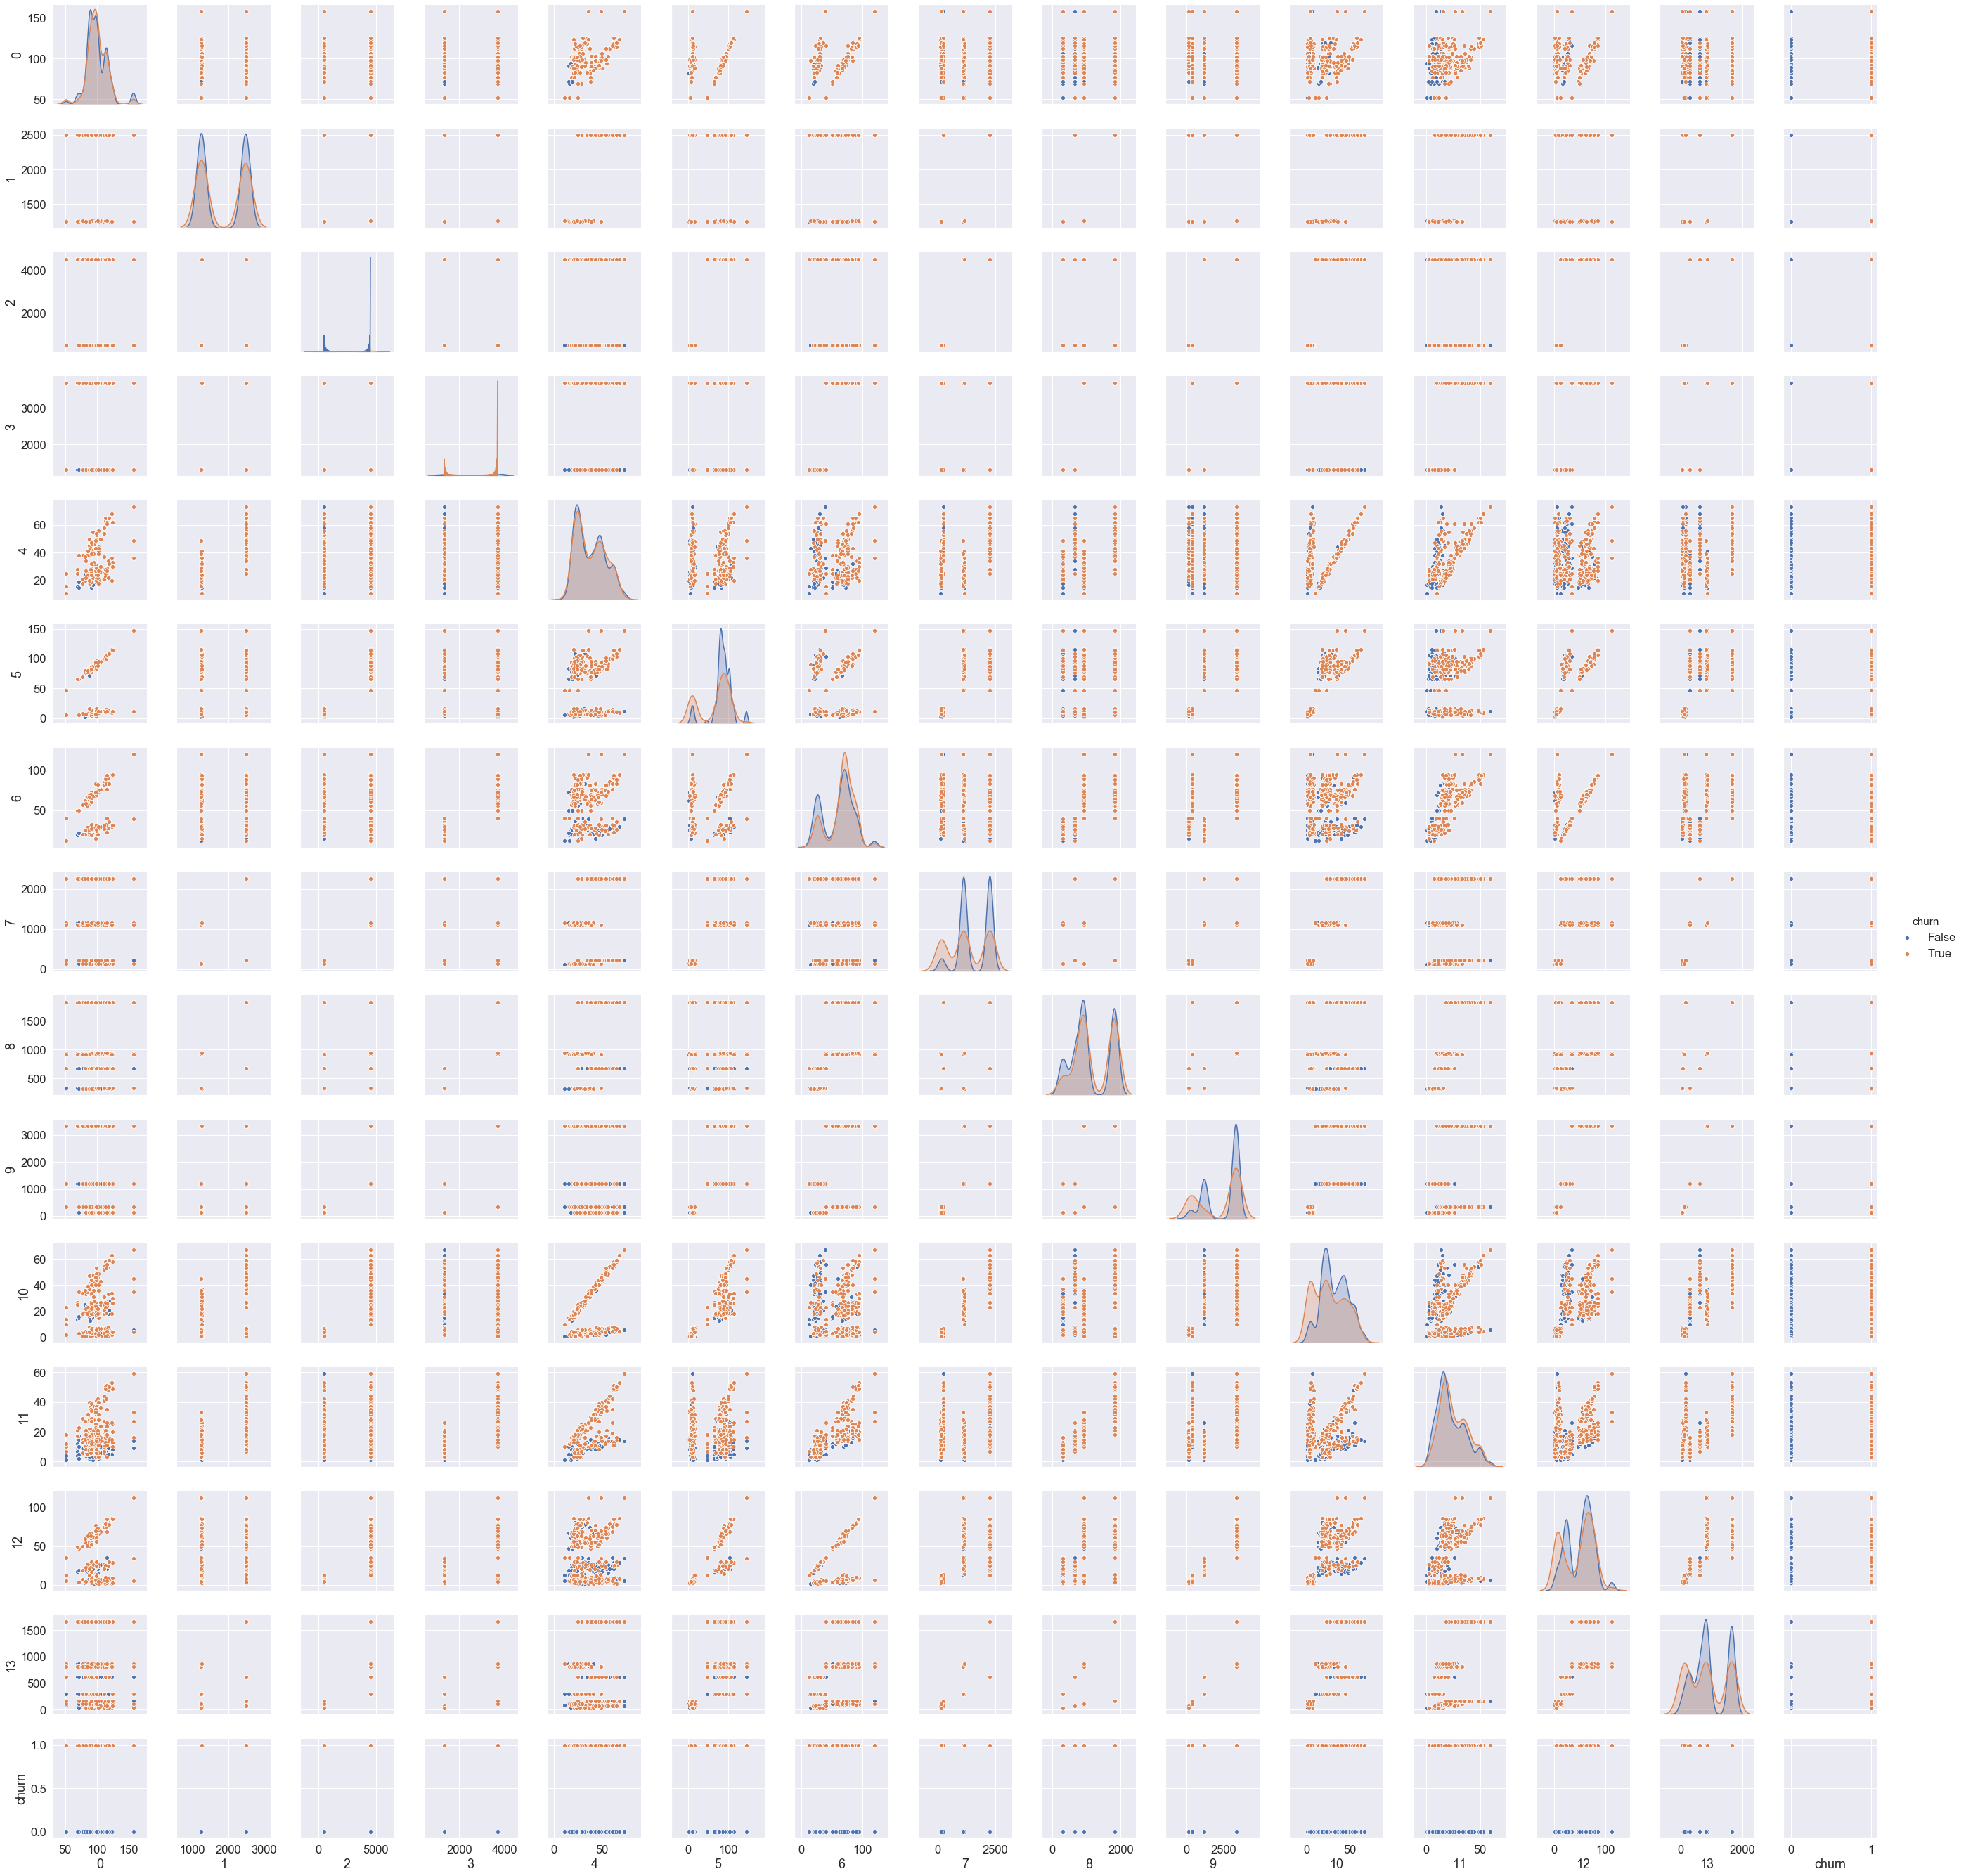

In [47]:
sns.pairplot(treino[novas_variaveis_churn].rename(columns = mapeamento2),hue = 'churn')

In [48]:
#Vamos explorar os novos dados
explore_describe(treino)

variable     type  na  na_pct  \
0                                   account_length    int64   0     0.0   
1                               international_plan     bool   0     0.0   
2                                  voice_mail_plan     bool   0     0.0   
3                            number_vmail_messages    int64   0     0.0   
4                                total_day_minutes  float64   0     0.0   
5                                  total_day_calls    int64   0     0.0   
6                                total_eve_minutes  float64   0     0.0   
7                                  total_eve_calls    int64   0     0.0   
8                              total_night_minutes  float64   0     0.0   
9                                total_night_calls    int64   0     0.0   
10                              total_intl_minutes  float64   0     0.0   
11                                total_intl_calls    int64   0     0.0   
12                   number_customer_service_calls    int64   0     0.0   
13                                           churn     bool   0     0.0   
14                                         state_N  float64   0     0.0   
15                                     area_code_N  float64   0     0.0   
16                            international_plan_N  float64   0     0.0   
17                               voice_mail_plan_N  float64   0     0.0   
18                               state_area_code_N  float64   0     0.0   
19                      state_international_plan_N  float64   0     0.0   
20                         state_voice_mail_plan_N  float64   0     0.0   
21                  area_code_international_plan_N  float64   0     0.0   
22                     area_code_voice_mail_plan_N  float64   0     0.0   
23            international_plan_voice_mail_plan_N  float64   0     0.0   
24            state_area_code_international_plan_N  float64   0     0.0   
25               state_area_code_voice_mail_plan_N  float64   0     0.0   
26      state_international_plan_voice_mail_plan_N  float64   0     0.0   
27  area_code_international_plan_voice_mail_plan_N  float64   0     0.0   

    unique   min quat25 median     mean quat75    max      std    skewness  \
0      212     1     74    101   101.06    127    243    39.82   0.0966063   
1        2     -      -      -        -      -      -        -           -   
2        2     -      -      -        -      -      -        -           -   
3       46     0      0      0      8.1     20     51    13.69     1.26482   
4     1667     0  143.7  179.4   179.78  216.4  350.8    54.47  -0.0290771   
5      119     0     87    101   100.44    114    165    20.07   -0.111787   
6     1611     0  166.6  201.4   200.98  235.3  363.7    50.71  -0.0238775   
7      123     0     87    100   100.11    114    170    19.92  -0.0555631   
8     1591  23.2    167  201.2   200.87  235.3    395    50.57  0.00892129   
9      120    33     87    100   100.11    113    175    19.57   0.0324996   
10     162     0    8.5   10.3    10.24   12.1     20     2.79   -0.245136   
11      21     0      3      4     4.48      6     20     2.46     1.32148   
12      10     0      1      1     1.56      2      9     1.32     1.09136   
13       2     -      -      -        -      -      -        -           -   
14      32    52     90     99   100.77    112    158    16.91    0.918951   
15       3  1246   1246   1259  1869.46   2495   2495   621.35   0.0136425   
16       2   473   4527   4527  4134.13   4527   4527  1199.49    -2.72633   
17       2  1323   1323   3677  3025.82   3677   3677  1053.17    -0.99914   
18      46    11     25     37    38.31     50     73    15.04    0.394041   
19      46     2     78     87    83.54    100    147    28.34      -1.224   
20      47    12     32     69    61.34     76    119    24.45   -0.234527   
21       6   109   1108   1150  1551.25   2269   2269   705.55   -0.348307   
22       6   323    674    936   1127.7   1821   1821   549.47    0.1938

In [49]:
#Salvando os dados tratados
dados.to_csv('treino_teste.csv')

## Seleção de variáveis

Como agora todas as variáveis são do tipo numéricas, podemos aplicar um PCA, para veficar a relevancia das variáveis a um modelo de Regressão Logística.

Contudo, para aplicarmos PCA, será necessária a padronização das variáveis

#### Tratamento de *outliers*

Vamos realizar um tratamento dos *outliers* antes de padronizar os dados

In [3]:
#Carregando os dados de treino e teste depois do tratamento dos dados iniciais
dados = pd.read_csv('treino_teste.csv')
dados = dados.set_index(['tipo_dado','index'])

In [10]:
#Vamos jogar os dados outliers para a media (sem considerar os outliers)
treino = dados.loc['treino']    
numericas = explore_describe(treino)['variable'][explore_describe(treino)['type'].\
                                         map(lambda x: True if (('int' in str(x)) or ('float' in str(x))) else False)].to_list()        
desvios_medias = outliers(numericas).fit(treino)
treino = desvios_medias.transform(treino)
treino

account_length  international_plan  voice_mail_plan  \
index                                                        
0               128.0               False             True   
1               107.0               False             True   
2               137.0               False            False   
3                84.0                True            False   
4                75.0                True            False   
...               ...                 ...              ...   
3328            192.0               False             True   
3329             68.0               False            False   
3330             28.0               False            False   
3331            184.0                True            False   
3332             74.0               False             True   

       number_vmail_messages  total_day_minutes  total_day_calls  \
index                                                              
0                       25.0              265.1            110.0   
1                       26.0              161.6            123.0   
2                        0.0              243.4            114.0   
3                        0.0              299.4             71.0   
4                        0.0              166.7            113.0   
...                      ...                ...              ...   
3328                    36.0              156.2             77.0   
3329                     0.0              231.1             57.0   
3330                     0.0              180.8            109.0   
3331                     0.0              213.8            105.0   
3332                    25.0              234.4            113.0   

       total_eve_minutes  total_eve_calls  total_night_minutes  \
index                                                            
0                  197.4             99.0                244.7   
1                  195.5            103.0                254.4   
2                  121.2            110.0                162.6   
3                   61.9             88.0                196.9   
4                  148.3            122.0                186.9   
...                  ...              ...                  ...   
3328               215.5            126.0                279.1   
3329               153.4             55.0                191.3   
3330               288.8             58.0                191.9   
3331               159.6             84.0                139.2   
3332               265.9             82.0                241.4   

       total_night_calls  ...  state_area_code_N  state_international_plan_N  \
index                     ...                                                  
0                   91.0  ...               50.0                        87.0   
1                  103.0  ...               61.0                       104.0   
2                  104.0  ...               58.0                       100.0   
3                   89.0  ...               29.0                        12.0   
4                  121.0  ...               38.0                         9.0   
...                  ...  ...                ...                         ...   
3328                83.0  ...               49.0                        83.0   
3329               123.0  ...               73.0                       147.0   
3330                91.0  ...               29.0                        86.0   
3331               137.0  ...               23.0                        10.0   
3332                77.0  ...               47.0                        77.0   

       state_voice_mail_plan_N  area_code_international_plan_N  \
index                                                            
0                         26.0                          2269.0   
1                         40.0                          2269.0   
2                         85.0                          2269.0   
3                         76.0                           109.0   
4                  

In [14]:
#Salvando os dados de desvios e medias
pickle.dump(desvios_medias,open('descritiva/descritiva.sav','wb'))

### Padronização dos dados

In [11]:
#Dividindo as variáveis que compõem o dataset da variável target
X = treino.drop(columns="churn")
y = treino.churn

In [12]:
parametros_dados_padronizados = StandardScaler().fit(X)
X_norm = parametros_dados_padronizados.transform(X)
X_norm

array([[ 0.69058467, -0.32758048,  1.6170861 , ..., -0.73725806,
        -1.03876918, -0.59811604],
       [ 0.15743589, -0.32758048,  1.6170861 , ...,  0.19494266,
        -0.61647729, -0.59811604],
       [ 0.919077  , -0.32758048, -0.61839626, ...,  1.59324375,
         1.07269029,  1.30802575],
       ...,
       [-1.84821903, -0.32758048, -0.61839626, ..., -0.11579091,
         0.42005736, -0.22592153],
       [ 2.11231474,  3.05268496, -0.61839626, ..., -0.65957466,
        -1.65301194, -1.50150078],
       [-0.68036933, -0.32758048,  1.6170861 , ..., -0.97030824,
        -1.11554953, -0.59811604]])

In [13]:
#Salvando os parâmetros padronizados
pickle.dump(parametros_dados_padronizados,open('parametros/parametros.sav','wb'))

### Aplicando PCA

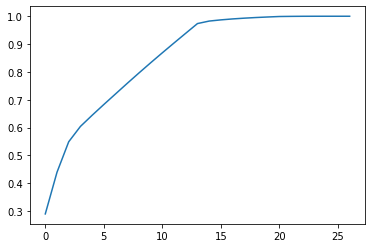

In [15]:
#Vamos testar como se comporta o PCA, variando a quantidade de componentes
variance_ratio = [sum(PCA(n_components=i).fit(X_norm,y).explained_variance_ratio_) for i in range(1,28)]
plt.plot(variance_ratio)

Nota-se que, realmente, não há a necessidade de tantas variáveis para representar 100% dos dados. Com 14 componentes, já é possível obter 97% das informações do dataset

In [16]:
pd.DataFrame({"Qtde_Componetes": range(1,28),"Representatividade":variance_ratio})

Qtde_Componetes  Representatividade
0                 1            0.289771
1                 2            0.439470
2                 3            0.548965
3                 4            0.604042
4                 5            0.644166
5                 6            0.682883
6                 7            0.720884
7                 8            0.758873
8                 9            0.796175
9                10            0.832802
10               11            0.868706
11               12            0.904036
12               13            0.938952
13               14            0.973693
14               15            0.982656
15               16            0.986944
16               17            0.990372
17               18            0.993098
18               19            0.995406
19               20            0.997315
20               21            0.999069
21               22            0.999557
22               23            0.999862
23               24            0.999966
24               25            1.000000
25               26            1.000000
26               27            1.000000

In [17]:
#Portanto, vamos adotar 14 componentes
pca = PCA(n_components=14).fit(X_norm)
X_PCA = pca.transform(X_norm)
X_PCA

array([[ 2.0313509 , -3.26933483,  1.06354896, ...,  0.16592532,
         1.04413265, -0.38399197],
       [ 0.95750042, -3.71714555,  1.51987311, ...,  0.74427474,
        -0.02546729, -0.48813361],
       [-3.7766698 , -0.56642516,  1.35250772, ..., -0.98516339,
         0.67958278,  1.03414992],
       ...,
       [-0.3250975 ,  1.28059366, -1.56709135, ...,  2.24517074,
         0.37471266,  1.29301637],
       [ 4.05851567,  4.79636026,  2.06228465, ..., -2.73773403,
        -1.13235062,  0.96319402],
       [ 2.35312747, -3.11507218,  1.0028172 , ...,  1.61010638,
         1.52834237,  0.51090027]])

In [18]:
#Salvando os parametros do PCA
pickle.dump(pca,open('PCA/PCA.sav','wb'))

## Aplicando modelo de classificação

Vamos realizar alguns testes com alguns modelos

In [20]:
modelos = {"LR":LogisticRegression(),
          "LA":LinearDiscriminantAnalysis(),
          "KNN":KNeighborsClassifier(),
          "NB":GaussianNB(),
          "TREE": DecisionTreeClassifier(),
          "SVM":SVC(),
          "XGB":XGBClassifier(),
          "GBC":GradientBoostingClassifier(),
          "ABC":AdaBoostClassifier(),
          "RF":RandomForestClassifier(),
          "MLP": MLPClassifier(),
          "SGD": SGDClassifier()}

X_treino = X_PCA.copy()
y_treino = y.copy()
CrossValidation = KFold(n_splits=11)
resultados = []
scoring = 'balanced_accuracy'
for nome_modelo,modelo in modelos.items():
    resultados.append(cross_val_score(estimator=modelo,X = X_treino, y= y_treino, cv= CrossValidation,scoring = scoring))
    print("%s com média de %s de %.2f" % (nome_modelo,scoring,np.mean(resultados[len(resultados)-1])))

LR com média de balanced_accuracy de 0.59
LA com média de balanced_accuracy de 0.60
KNN com média de balanced_accuracy de 0.60
NB com média de balanced_accuracy de 0.62
TREE com média de balanced_accuracy de 0.66
SVM com média de balanced_accuracy de 0.66
XGB com média de balanced_accuracy de 0.69
GBC com média de balanced_accuracy de 0.62
ABC com média de balanced_accuracy de 0.61
RF com média de balanced_accuracy de 0.61
MLP com média de balanced_accuracy de 0.79
SGD com média de balanced_accuracy de 0.58


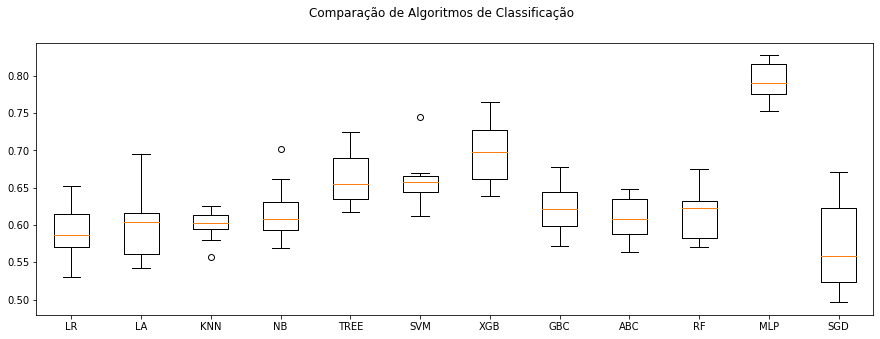

In [21]:
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize = (15,5))
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(modelos.keys())
plt.show()

Os resultados foram melhores utilizando-se *Random Forest*, mas vamos avaliar o modelo, fazendo algumas alterações nos parâmetros, também, para a Regressão Logística

## Otimizando os modelos

In [39]:
#Quantidade de iterações
iterations = 500

#Criando os valores de Grid para a busca e otimização
valores_grid = {"penalty":["l1", "l2", "elasticnet"],
               "C": [0,0.01,0.05,0.1,0.5,0.8,1,2,5],
               "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
               "max_iter":[10,30,50,100,500,1000]}


# Criando o grid e utilizando como score (padrão) a acurácia
LRsearch = RandomizedSearchCV(estimator = modelos['LR'], 
                             param_distributions = valores_grid, 
                             n_iter = iterations,
                             scoring = scoring,
                             cv = CrossValidation)
LRsearch.fit(X_treino, y_treino)
print(LRsearch.best_params_)
print('Melhor score encontrado foi %.2f' % (LRsearch.best_score_))

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 10, 'C': 5}
Melhor score encontrado foi 0.59


In [40]:
#Salvando o melhor modelo encontrado
pickle.dump(LRsearch.best_estimator_, open('modelos/modelo_LR.sav', 'wb'))

Vamos agora otimizar o modelo para a rede neural MLP

In [41]:
#Quantidade de iterações
iterations = 500

#Criando os valores de Grid para a busca e otimização
valores_grid = {"activation":["identity", "logistic", "tanh", "relu"],
               "alpha": [0,0.0001,0.01,0.1,0.5,0.8,1],
               "hidden_layer_sizes": [(100,),(33,33,33),(50,50),(25,25,25,25)],
               "learning_rate":["constant", "invscaling", "adaptive"]}


# Criando o grid e utilizando como score (padrão) a acurácia
MLPsearch = RandomizedSearchCV(estimator = modelos['MLP'], 
                             param_distributions = valores_grid, 
                             n_iter = iterations,
                             scoring = scoring,
                             cv = CrossValidation)
MLPsearch.fit(X_treino, y_treino)
print(MLPsearch.best_params_)
print('Melhor score encontrado foi %.2f' % (MLPsearch.best_score_))

{'learning_rate': 'invscaling', 'hidden_layer_sizes': (33, 33, 33), 'alpha': 0.5, 'activation': 'relu'}
Melhor score encontrado foi 0.83


In [42]:
#Salvando o melhor modelo encontrado
pickle.dump(MLPsearch.best_estimator_, open('modelos/modelo_MLP.sav', 'wb'))

______________________________________________________________________________________________________________________________________________

## Carregando os modelos salvos e parâmetros salvos

In [43]:
parametros_dados_padronizados = pickle.load(open('parametros/parametros.sav','rb'))
MLPmodelo = pickle.load(open('modelos/modelo_MLP.sav','rb'))
LRmodelo = pickle.load(open('modelos/modelo_LR.sav','rb'))
validacao = pd.read_csv("validacao.csv")
pca = pickle.load(open('PCA/PCA.sav','rb'))
dados = pd.read_csv('treino_teste.csv')
desvios_media = pickle.load(open('descritiva/descritiva.sav','rb'))
#count_columns = pickle.load(open('contagem/contagem.sav','rb'))

In [44]:
dados = dados.set_index(['tipo_dado','index'])
dados

account_length  international_plan  voice_mail_plan  \
tipo_dado index                                                        
treino    0                 128               False             True   
          1                 107               False             True   
          2                 137               False            False   
          3                  84                True            False   
          4                  75                True            False   
...                         ...                 ...              ...   
teste     1662               50               False             True   
          1663              152               False            False   
          1664               61               False            False   
          1665              109               False            False   
          1666               86               False             True   

                 number_vmail_messages  total_day_minutes  total_day_calls  \
tipo_dado index                                                              
treino    0                         25              265.1              110   
          1                         26              161.6              123   
          2                          0              243.4              114   
          3                          0              299.4               71   
          4                          0              166.7              113   
...                                ...                ...              ...   
teste     1662                      40              235.7              127   
          1663                       0              184.2               90   
          1664                       0              140.6               89   
          1665                       0              188.8               67   
          1666                      34              129.4              102   

                 total_eve_minutes  total_eve_calls  total_night_minutes  \
tipo_dado index                                                            
treino    0                  197.4               99                244.7   
          1                  195.5              103                254.4   
          2                  121.2              110                162.6   
          3                   61.9               88                196.9   
          4                  148.3              122                186.9   
...                            ...              ...                  ...   
teste     1662               223.0              126                297.5   
          1663               256.8               73                213.6   
          1664               172.8              128                212.4   
          1665               171.7               92                224.4   
          1666               267.1              104                154.8   

                 total_night_calls  ...  state_area_code_N  \
tipo_dado index                     ...                      
treino    0                     91  ...               50.0   
          1                    103  ...               61.0   
          2                    104  ...               58.0   
          3                     89  ...               29.0   
          4                    121  ...               38.0   
...                            ...  ...                ...   
teste     1662                 116  ...               24.0   
          1663                 113  ...               73.0   
          1664                  97  ...               45.0   
          1665                  89  ...               23.0   
          1666                 100  ...               50.0   

                 state_international_plan_N  state_voice_mail_plan_N  \
tipo_dado index                                                        
treino    0                            87.0                     26.0   
          1                           104.0          

## Comparando os resultados do modelo com os dados de teste

In [45]:
#Vamos montar um pipeline para tratar os dados de validação, separados ao começo do estudo
stepPadroniza = [('tratamento_outliers',desvios_media),
                 ('padroniza',parametros_dados_padronizados),
                 ('PCA',pca)]
pipe = Pipeline(stepPadroniza)

In [46]:
#Preparando os dados de teste para que fiquem padronizados
X_teste = dados.loc['teste'].drop(columns='churn')
y_teste = dados.loc['teste'].churn
X_teste_PCA = pipe.transform(X_teste)

In [47]:
#Rodando o modelo LR para os dados de teste padronizados
predict_probaLR = LRmodelo.predict_proba(X_teste_PCA)
ProbLR = pd.DataFrame(predict_probaLR)
ProbLR.columns = ['no_churn','yes_churn']
ProbLR['Decisao'] = ProbLR.apply(lambda x: 'no' if x['no_churn'] > x['yes_churn'] else 'yes', axis=1)
ProbLR

no_churn  yes_churn Decisao
0     0.917248   0.082752      no
1     0.945718   0.054282      no
2     0.753907   0.246093      no
3     0.840992   0.159008      no
4     0.926436   0.073564      no
...        ...        ...     ...
1662  0.852416   0.147584      no
1663  0.616828   0.383172      no
1664  0.947847   0.052153      no
1665  0.963972   0.036028      no
1666  0.987027   0.012973      no

[1667 rows x 3 columns]

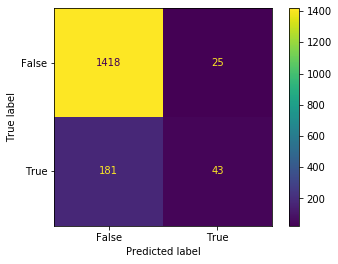

In [48]:
#Vamos montar uma matriz de confusão para o modelo de Regressao Logistica
plot_confusion_matrix(LRmodelo, X = X_teste_PCA, y_true = y_teste)

In [49]:
#Calculando o f1 score para o modelo LR
f1_score(y_pred=LRmodelo.predict(X_teste_PCA),y_true=y_teste)

0.2945205479452055

In [50]:
#Calculando a acuracia score para o modelo LR
accuracy_score(y_pred=LRmodelo.predict(X_teste_PCA),y_true=y_teste)

0.8764247150569886

In [51]:
#Agora, com a Random Forest
predict_probaMPL = MLPmodelo.predict_proba(X_teste_PCA)
ProbMLP = pd.DataFrame(predict_probaMLP)
ProbMLP.columns = ['no_churn','yes_churn']
ProbMLP['Decisao'] = ProbMLP.apply(lambda x: 'no' if x['no_churn'] > x['yes_churn'] else 'yes', axis=1)
ProbMLP

no_churn  yes_churn Decisao
0     0.827214   0.172786      no
1     0.994052   0.005948      no
2     0.960288   0.039712      no
3     0.982889   0.017111      no
4     0.974642   0.025358      no
...        ...        ...     ...
1662  0.988382   0.011618      no
1663  0.950547   0.049453      no
1664  0.995745   0.004255      no
1665  0.999377   0.000623      no
1666  0.981930   0.018070      no

[1667 rows x 3 columns]

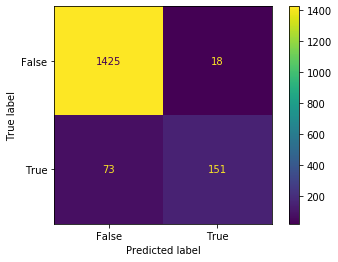

In [52]:
#Agora vamos montar uma matriz de confusão para o modelo de Random Forest
plot_confusion_matrix(MLPmodelo, X = X_teste_PCA, y_true = y_teste)

In [53]:
#Calculando o f1 score para o modelo RF
f1_score(y_pred=MLPmodelo.predict(X_teste_PCA),y_true=y_teste)

0.7684478371501273

In [54]:
#Calculando a acuracia score para o modelo RF
accuracy_score(y_pred=MLPmodelo.predict(X_teste_PCA),y_true=y_teste)

0.9454109178164367